In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from ratsql.utils.analysis import cal_attention_flow
from ratsql.commands.infer import Inferer
from run_all import test_example, load_model, TestInfo
import _jsonnet
from search import read_data, match, show_results
import warnings

In [2]:
# Paths
project_dir = "/home/hkkang/NL2QGM"
template = "logdir/spider_bert_run_no_join_cond_seed_{}/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed={},join_cond=false/ie_dirs/bert_run_true_1-step_41600-eval.json"
template = os.path.join(project_dir, template)

eval_paths = [template.format(0,0)]
eval_paths += [template.format(2,2)]
eval_paths += [template.format(3,3)]

infer_paths = [path.replace("-eval.json", "-infer.jsonl") for path in eval_paths]
debug_paths = [path.replace("-eval.json", "-debug.jsonl") for path in eval_paths]

In [3]:
# Utils
def is_int(text):
    try:
        int(text)
        return True
    except:
        return False
    
def load_json_custom(path):
    result = json.load(open(path))['per_item']
    print(len(result))
    return result

def load_jsonl(path):
    with open(path, 'r') as f:
        results = [json.loads(line) for line in f.readlines()]
    return results
    
def get(t_list, idx):
    return [item[idx] for item in t_list]
    
def get_consistently_wrong_indices(eval_list):
    same_lengths = [len(eval_list[i-1]) == len(eval_list[i]) for i in range(1, len(eval_list))]
    assert False not in same_lengths
    indices = []
    for idx in range(len(eval_list[0])):
        correctness = [result[idx]['exact'] for result in eval_list]
        # Incorrect in all models
        if True not in correctness:
            indices += [idx]
    return indices

def get_info_list(is_testing=False):
    eval_list = [load_json_custom(path.replace('.json', '-testing.json') if is_testing else path)
                      for path in eval_paths]
    debug_list = [load_jsonl(path.replace('.jsonl', '-testing.jsonl') if is_testing else path) 
                      for path in debug_paths]
    infer_list = [load_jsonl(path.replace('.jsonl', '-testing.jsonl') if is_testing else path)
                      for path in infer_paths]
    wrong_indices = get_consistently_wrong_indices(eval_list)

    return wrong_indices, eval_list, debug_list, infer_list

In [4]:
# Visualization
def draw_question_schema_link(question, schema, match_info, title=None):
    def parse_item(key, value):
        idx1, idx2 = [int(item) for item in key.split(',')]
        if value[-2:] == 'EM':
            value = 1
        elif value[-2:] == 'PM':
            value = 0.5
        elif value in ['CELLMATCH', 'NUMBER', 'TIME']:
            value = 1
        else:
            raise RuntimeError("should not be here!")
        return idx1, idx2, value

    weight_matrix = torch.zeros(len(question), len(schema))
    infos = [parse_item(key, value) for key, value in match_info.items()]
    for idx1, idx2, value in infos:
        weight_matrix[idx1][idx2] = value

    visualize_attention(weight_matrix, question, schema, title=title)    

    
def visualize_attention(mma, target_labels, source_labels, title=None):
    """
    Inputs:
        mma: nxn weight matrix
        source_labels: List of column labels
        target_labels: List of row labels
    """
    fig, ax = plt.subplots(figsize=(20,20), dpi=100)
    im = ax.imshow(mma)
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(mma.shape[1]), minor=False) # mma.shape[1] = target seq 길이
    ax.set_yticks(np.arange(mma.shape[0]), minor=False) # mma.shape[0] = input seq 길이
   
    # source words -> column labels
    ax.set_xticklabels(source_labels, minor=False)
    # target words -> row labels
    ax.set_yticklabels(target_labels, minor=False)
  
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
 
    plt.xticks(rotation=45)
 
    if title:
        ax.set_title(title)

    # Loop over data dimensions and create text annotations.
    for i in range(len(mma)):
        for j in range(len(mma[0])):
            text = ax.text(j, i, "{:.3f}".format(mma[i, j].item()), ha="center", va="center", color="k")
        
    plt.tight_layout()
    plt.show()

In [5]:
# Analysis
def analyze(eval_results, debug_results, infer_results, model_idx=0, inspect_step_idx=None):
    # Keep other models' info within this function for detailed comparison
    eval_result = eval_results[model_idx]
    debug_result = debug_results[model_idx]
    infer_result = infer_results[model_idx]

    inference_identical = False not in [eval_results[i-1]['predicted'] == eval_results[i]['predicted'] for i in range(1, len(eval_results))]
    print(f"Inference identical:{inference_identical}")

    # For easy referencing
    db_id = infer_result['db_id']
    nl = infer_result['question']
    nl_toks = infer_result['question_toks']
    gold = eval_result['gold']
    pred = eval_result['predicted']
    ## Schema and memory
    tables = [' '.join(item) for item in infer_result['schema']['tables']]
    columns = [' '.join(item[:-1]) for item in infer_result['schema']['columns']]
    memory = nl_toks+columns+tables
    ## Schema linking
    sc_link = infer_result['sc_link']
    cv_link = infer_result['cv_link']
    ## align_mat
    mc_align_matrix = torch.tensor(debug_result['mc_align_matrix'])
    mt_align_matrix = torch.tensor(debug_result['mt_align_matrix'])
    ## action scores
    decode_history = debug_result['history']
    ## encoder attention weight for each layers
    atts_list = debug_result['att_list']

    # Print Basic info
    print(f"DB_ID: {db_id}")
    print(f"NL: {nl}")
    print(f"GOLD: {gold}")
    print(f"PRED: {pred}")
    
    # Analyze Linking
    ## question - column linking
    draw_question_schema_link(nl_toks, columns, sc_link['q_col_match'], title="Question - Column linking")
    ## question - table linking
    draw_question_schema_link(nl_toks, tables, sc_link['q_tab_match'], title="Question - Table linking")
    ## question - column cell linking
    draw_question_schema_link(nl_toks, columns, dict(cv_link['cell_match'], **cv_link['num_date_match']),
                             title="Question - Cell linking") 

    # Analyze align matrix
    visualize_attention(mc_align_matrix, memory, columns, title="Memory - Column alignment")
    visualize_attention(mt_align_matrix, memory, tables, title="Memory - Table alignment")
    
    # Analyze attention flow in encoder
    att_flow = cal_attention_flow(torch.tensor(atts_list).squeeze(1))
    visualize_attention(att_flow, memory, memory, title="Encoder attention flow")
    
    # Analyze decoding steps
    for step, step_info in enumerate(decode_history):
        if inspect_step_idx != None and inspect_step_idx != step:
            continue
        print(f"Step: {step}")
        # For easy reference
        rule_left = step_info['rule_left']
        choices = step_info['choices']
        probs = step_info['probs']

        # Decoder: action choices and probs
        print(f"rule_left: {rule_left}")
        print(f"choices: {choices}")
        print(f"probs: {['{:.2f}'.format(prob*100) for prob in probs]}")

        # Decoder: hidden state - memory attention
        dec_att = torch.tensor(step_info['att_probs'])
        visualize_attention(dec_att.transpose(0,1), memory, ['hidden_state'],
                                title="Hidden state - Memory attention")

        # More info for column/table
        if rule_left in ['column', 'table']:
            # Decoder: memory-pointer probs
            memory_pointer_probs = torch.tensor(step_info['memory_pointer_probs'])
            visualize_attention(memory_pointer_probs.transpose(0, 1), 
                                memory, ['hidden_state'], title='Memory pointer probs')
            
            ## Decoder: attention flow of inputs to schema candidates
            # 1. alignment matrix and encoder attention flow
            if rule_left == 'column':
                target = columns
                align_mat = mc_align_matrix
                schema_att_flow = att_flow[len(nl_toks):len(nl_toks+columns)]
            else:
                target = tables
                align_mat = mt_align_matrix
                schema_att_flow = att_flow[len(nl_toks+columns):]
            align_mat = align_mat.unsqueeze(-1).repeat(1,1,len(memory))
            schema_att_flow = schema_att_flow.unsqueeze(0).repeat(len(memory), 1, 1)
            output1 = align_mat * schema_att_flow # (len_memory x len_schema x len_memory)
        
            # 2. hidden attention and output from (1)
            dec_att = dec_att.squeeze(0).reshape(len(memory), 1, 1).repeat(1, len(target), len(memory))
            att_flow_to_target_schema = torch.sum(dec_att * output1, dim=0)
            visualize_attention(att_flow_to_target_schema, target, memory,
                                   title=f"Attention flow to output {rule_left}")

In [6]:
# Load
wrong_indices, eval_list, debug_list, infer_list = get_info_list()
print(f"Consistenly wrong count:{len(wrong_indices)}")

1034
1034
1034
Consistenly wrong count:253


In [7]:
print(wrong_indices)

[5, 6, 16, 17, 43, 44, 47, 48, 50, 64, 65, 66, 68, 83, 84, 94, 96, 97, 98, 101, 102, 109, 110, 116, 123, 124, 129, 130, 131, 132, 133, 138, 140, 142, 154, 158, 159, 160, 161, 162, 166, 167, 168, 171, 172, 174, 175, 177, 178, 180, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 253, 254, 255, 256, 257, 258, 265, 336, 407, 408, 413, 423, 448, 451, 452, 453, 454, 459, 460, 470, 479, 480, 485, 486, 487, 488, 493, 494, 495, 500, 505, 520, 526, 533, 534, 536, 537, 539, 541, 542, 549, 550, 557, 558, 559, 560, 561, 571, 572, 575, 576, 578, 583, 584, 591, 592, 637, 642, 645, 646, 691, 707, 709, 712, 713, 716, 717, 724, 725, 726, 728, 736, 737, 738, 739, 744, 745, 748, 749, 754, 755, 757, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 792, 793, 798, 799, 809, 816, 817, 818, 819, 

In [8]:
def show_raw_data(item_idx):
    eval_results = get(eval_list, item_idx)
    debug_results = get(debug_list, item_idx)
    infer_results = get(infer_list, item_idx)
    
    db_id = infer_results[0]['db_id']
    nl = infer_results[0]['question']
    nl_toks = infer_results[0]['question_toks']
    gold = eval_results[0]['gold']
    preds = [item['predicted'] for item in eval_results]

    # Print Basic info
    print(f"\nidx:{item_idx}")
    print(f"DB_ID: {db_id}")
    print(f"NL: {nl}")
    print(f"GOLD: {gold}")
    for i in range(3):
        print(f"PRED{i}: {preds[i]}")

# for item_idx in wrong_indices:
#     show_raw_data(item_idx)
for item_idx in [64, 216, 247, 248, 549, 561, 784, 906, 914, 915, 916, 917, 937]:
    show_raw_data(item_idx)


idx:64
DB_ID: pets_1
NL: What are the ids of the students who do not own cats as pets?
GOLD: SELECT stuid FROM student EXCEPT SELECT T1.stuid FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'cat'
PRED0: SELECT Student.StuID FROM Student EXCEPT SELECT Has_Pet.StuID FROM Has_Pet WHERE Has_Pet.PetID = 'terminal'
PRED1: SELECT Student.StuID FROM Student EXCEPT SELECT Has_Pet.StuID FROM Has_Pet WHERE Has_Pet.PetID = 'terminal'
PRED2: SELECT Student.StuID FROM Student EXCEPT SELECT Has_Pet.StuID FROM Has_Pet WHERE Has_Pet.PetID = 'terminal'

idx:216
DB_ID: flight_2
NL: Count the number of United Airlines flights arriving in ASY Airport.
GOLD: SELECT count(*) FROM AIRLINES AS T1 JOIN FLIGHTS AS T2 ON T2.Airline  =  T1.uid WHERE T1.Airline  =  "United Airlines" AND T2.DestAirport  =  "ASY"
PRED0: SELECT Count(*) FROM airlines JOIN flights WHERE flights.DestAirport = 'terminal' AND airlines.Airline = 'terminal'
PRED1:

In [9]:
def api(wrong_indices, eval_list, debug_list, infer_list, model_idx=0, item_idx=0, step_idx=None, is_debugging=False):
    if not is_debugging:
        assert item_idx in wrong_indices
    print(f'Real item idx:{item_idx}')
    print(len(eval_list))
    eval_results = get(eval_list, item_idx)
    debug_results = get(debug_list, item_idx)
    infer_results = get(infer_list, item_idx)
    analyze(eval_results, debug_results, infer_results, model_idx=model_idx, inspect_step_idx=step_idx)

In [10]:
# Show pred for three different models
def show_raw_pred():
    for item_idx in wrong_indices:
        eval_results = get(eval_list, item_idx)
        debug_results = get(debug_list, item_idx)
        infer_results = get(infer_list, item_idx)

        db_id = infer_results[0]['db_id']
        nl = infer_results[0]['question']
        nl_toks = infer_results[0]['question_toks']
        gold = eval_results[0]['gold']
        preds = [item['predicted'] for item in eval_results]

        print(f"\nidx:{item_idx}")
        print(f"DB_ID: {db_id}")
        print(f"NL: {nl}")
        print(f"GOLD: {gold}")
        for p_idx, pred in enumerate(preds):
            print(f"PRED{p_idx}: {pred}")

Real item idx:225
3
Inference identical:False
DB_ID: flight_2
NL: What is the code of airport that has the highest number of flights?
GOLD: SELECT T1.AirportCode FROM AIRPORTS AS T1 JOIN FLIGHTS AS T2 ON T1.AirportCode  =  T2.DestAirport OR T1.AirportCode  =  T2.SourceAirport GROUP BY T1.AirportCode ORDER BY count(*) DESC LIMIT 1
PRED: SELECT flights.DestAirport FROM flights GROUP BY flights.DestAirport ORDER BY Count(*) Desc LIMIT 1


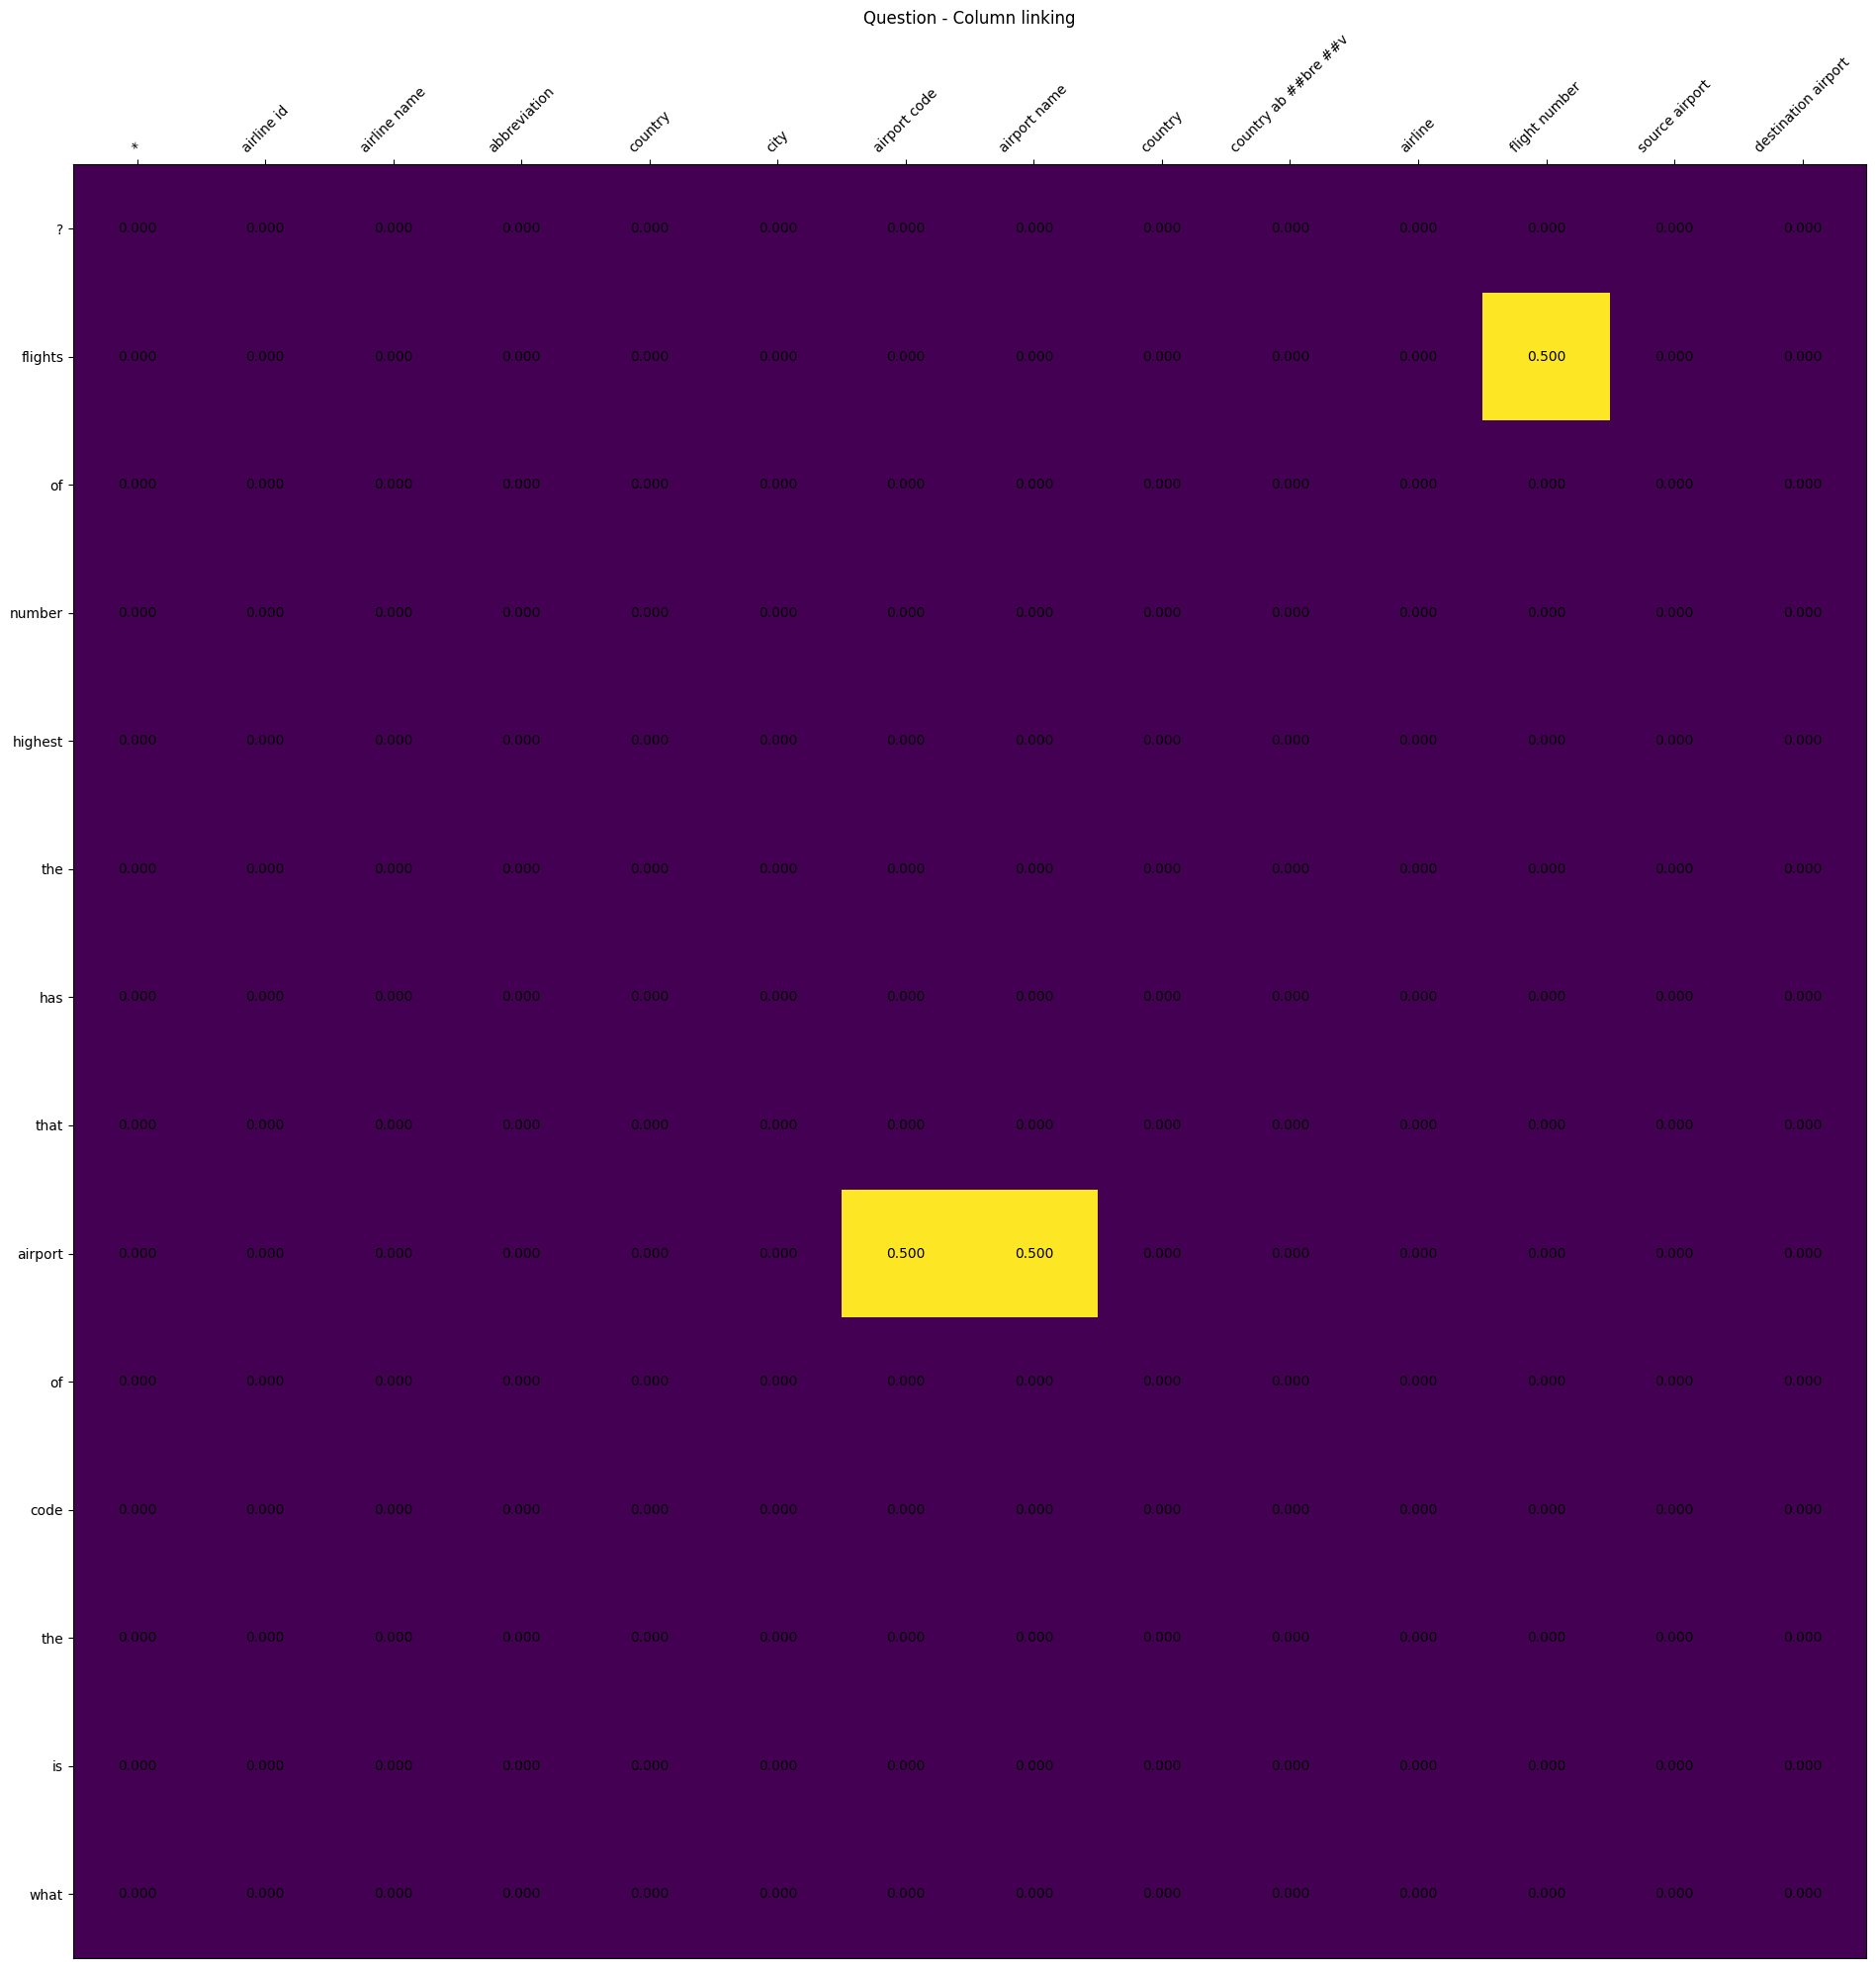

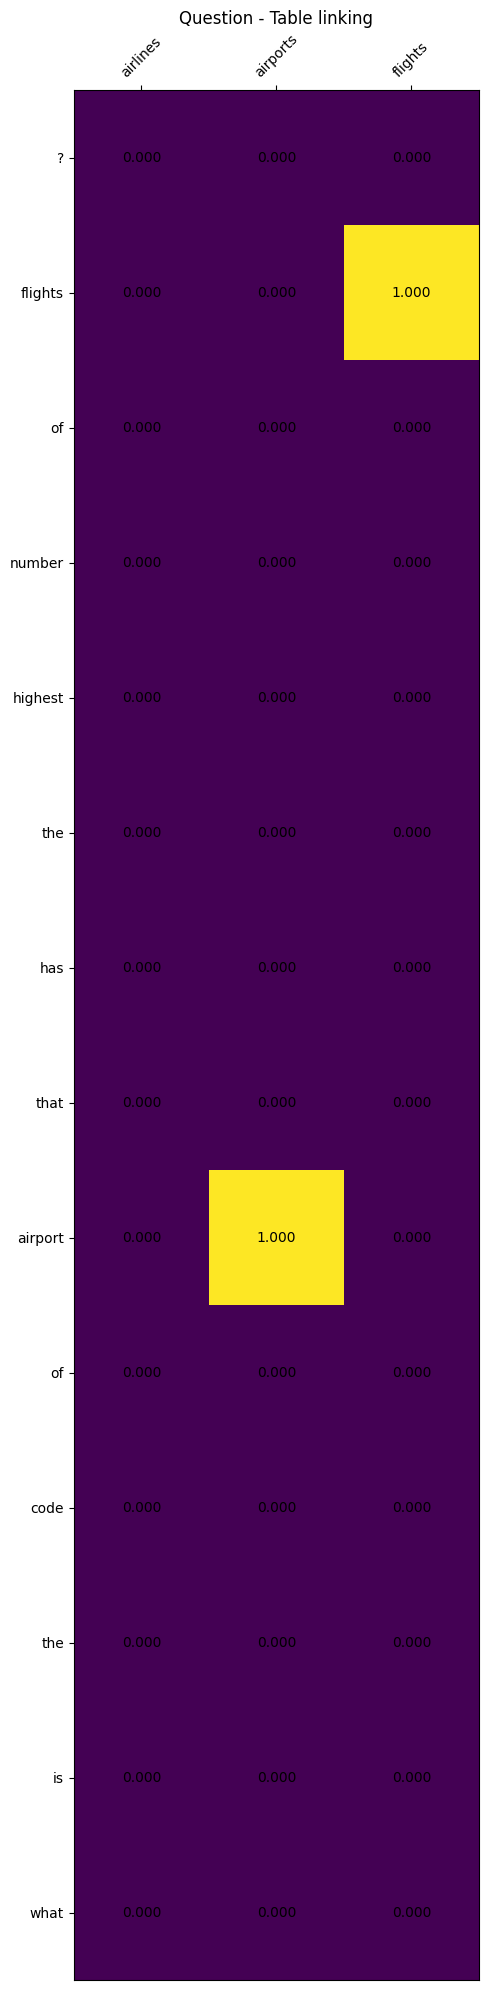

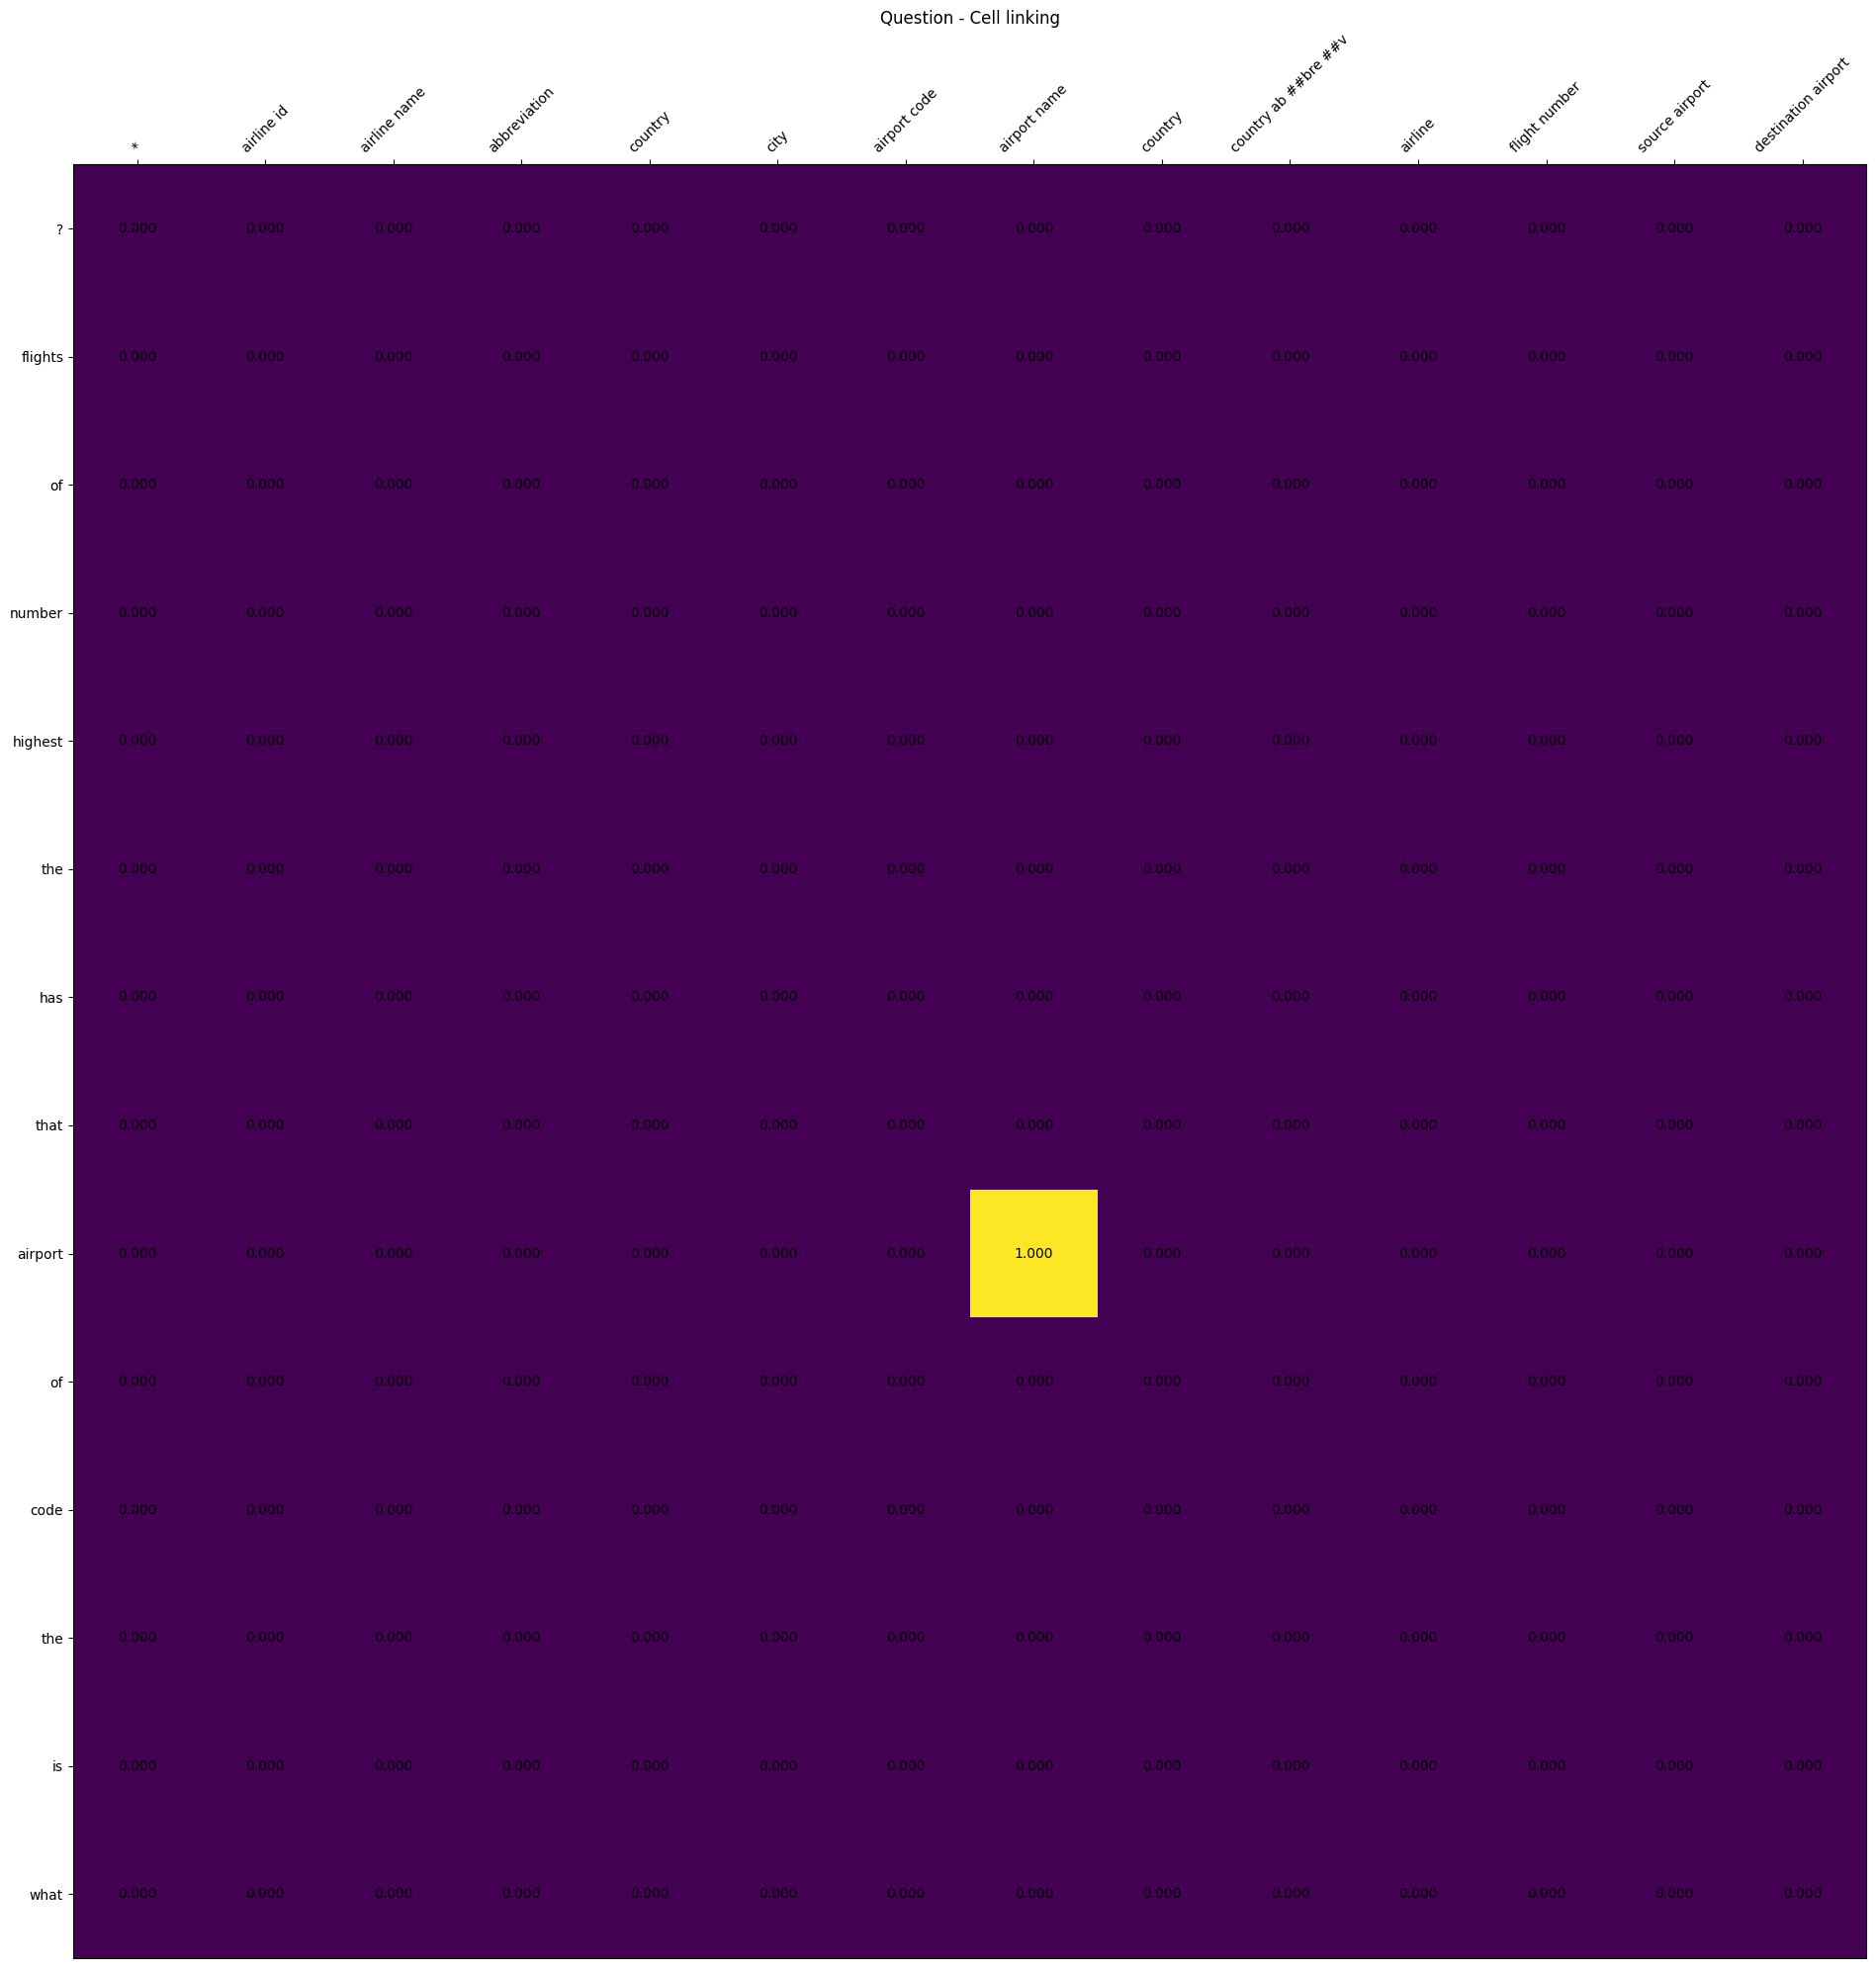

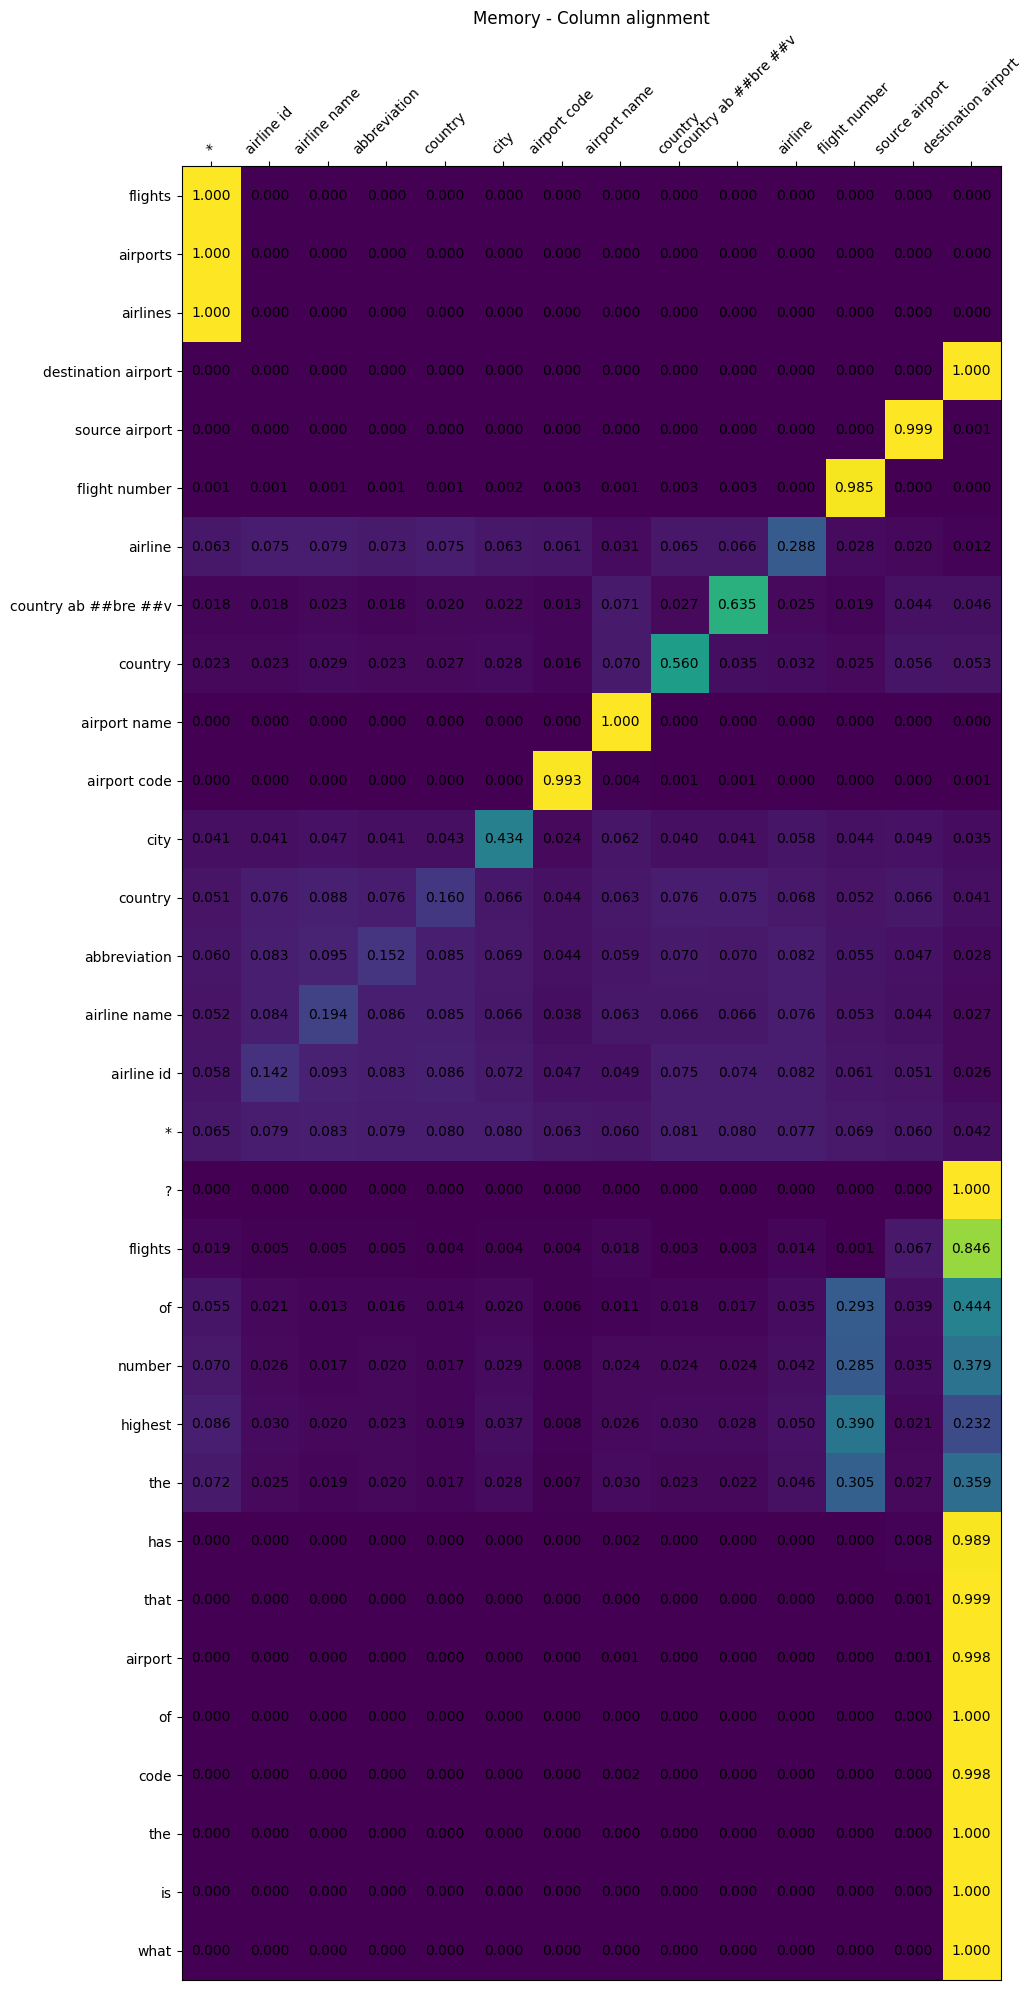

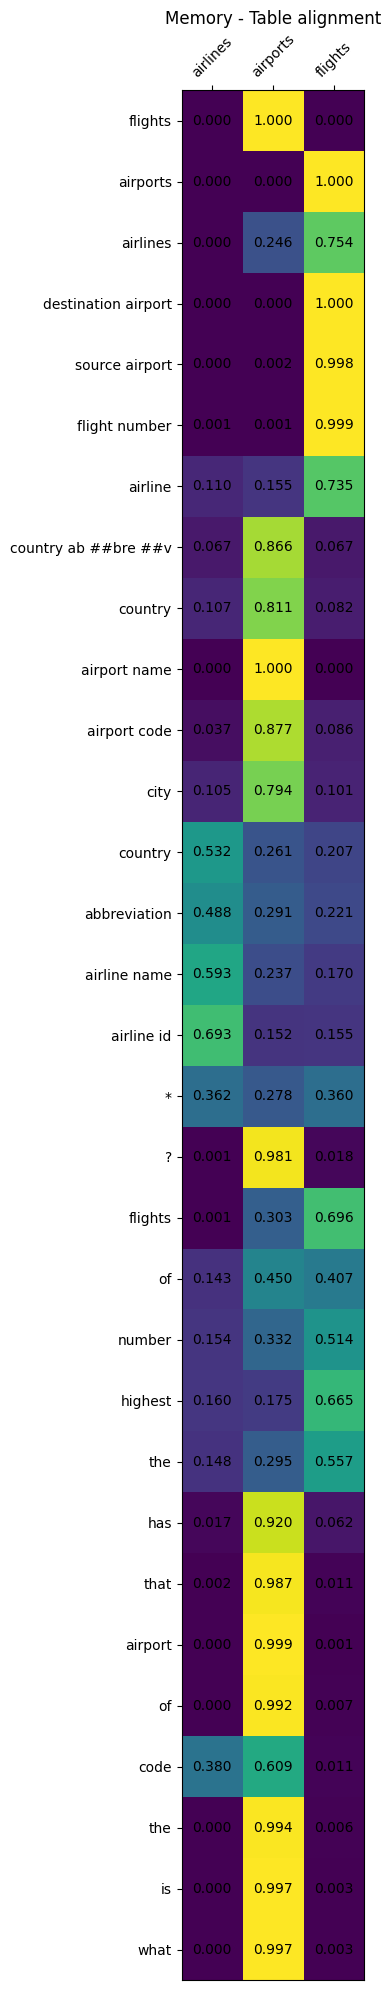

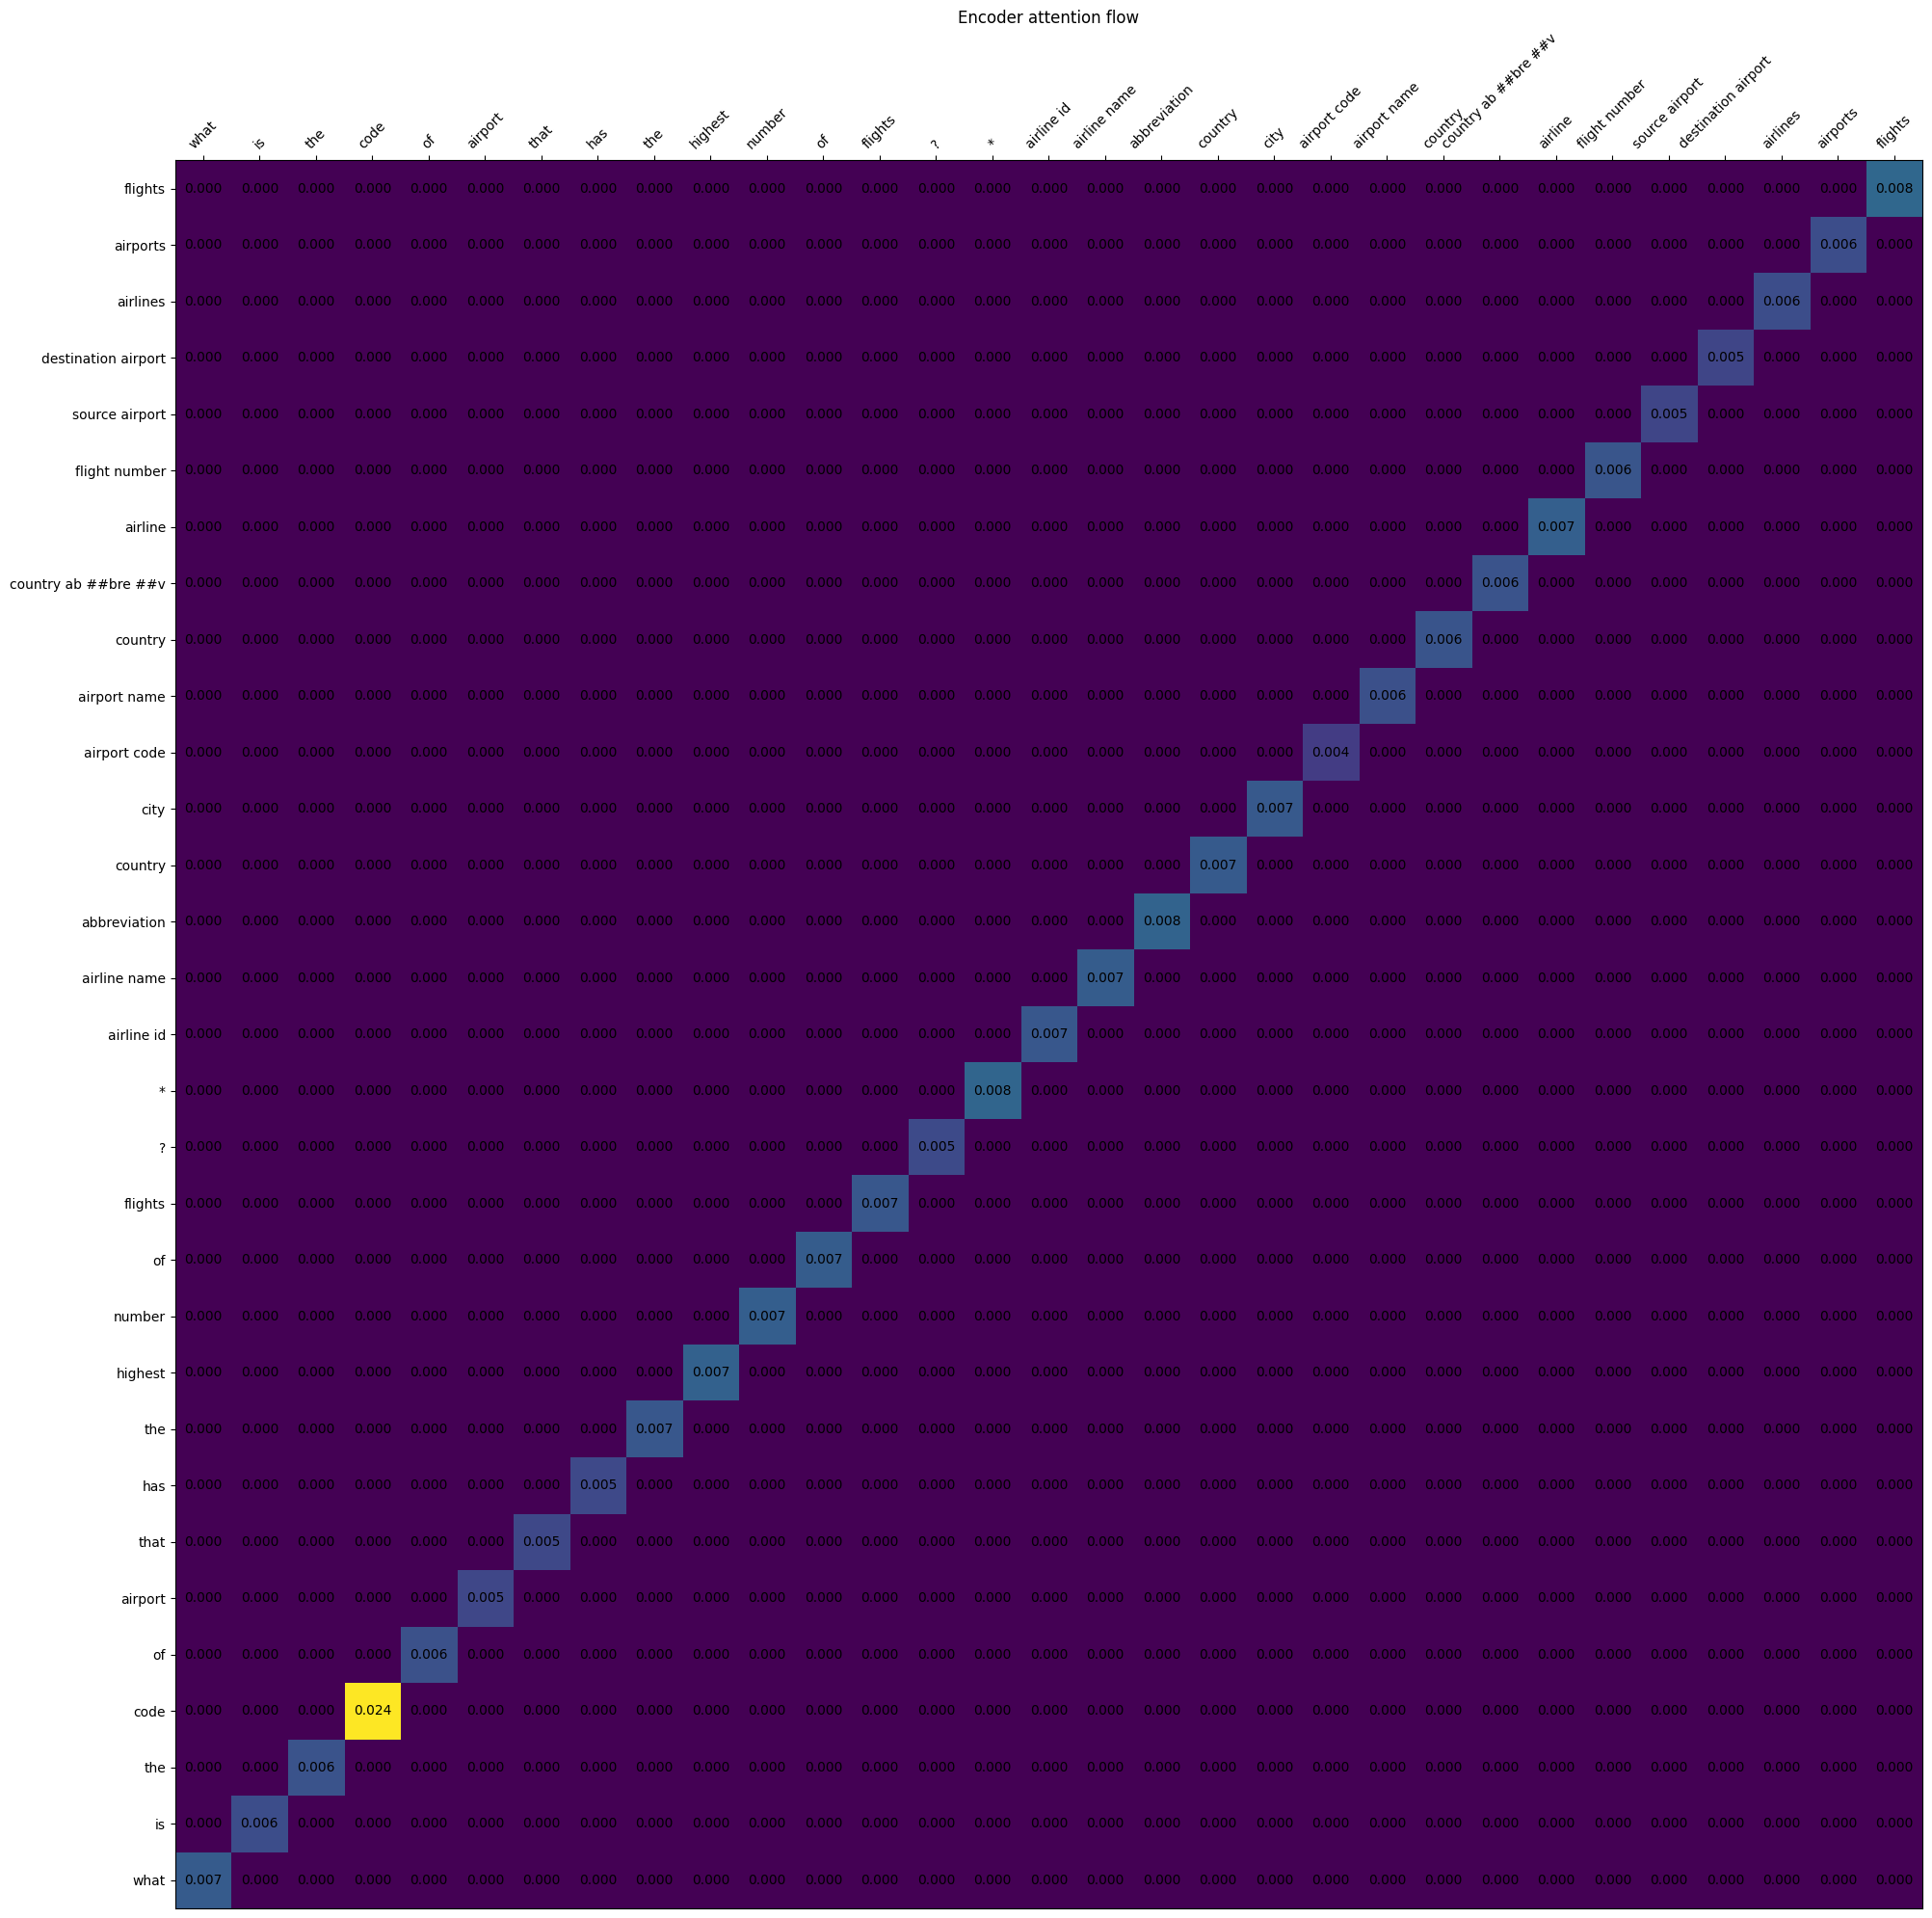

Step: 0
rule_left: sql
choices: [[True, True, True, True, True, True]]
probs: ['90.02']


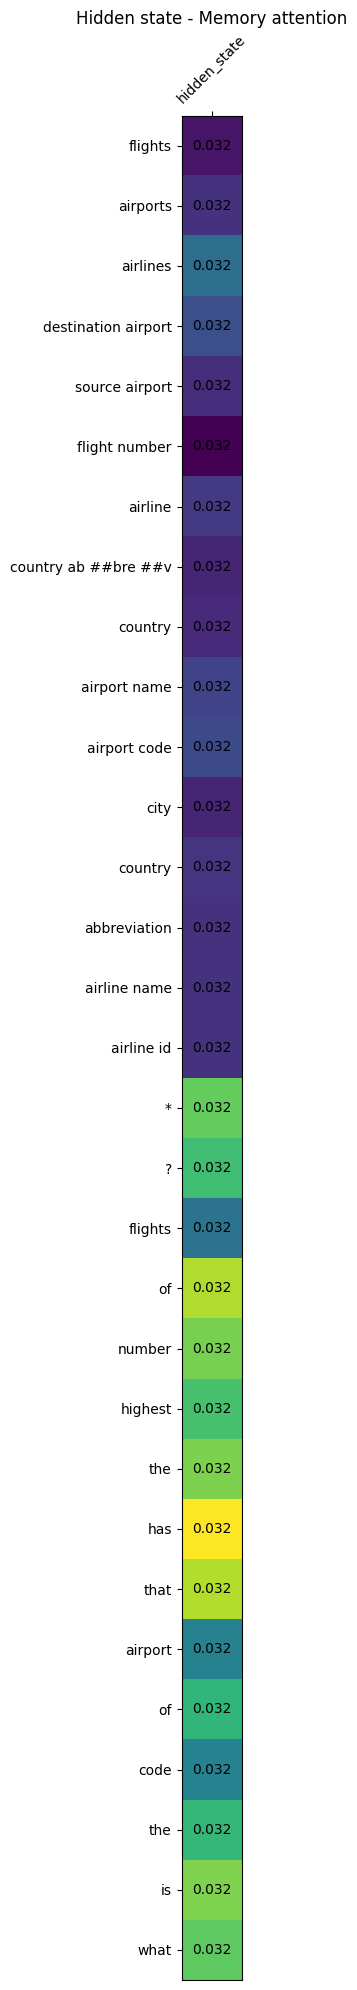

Step: 1
rule_left: select
choices: [['bool', True]]
probs: ['90.05']


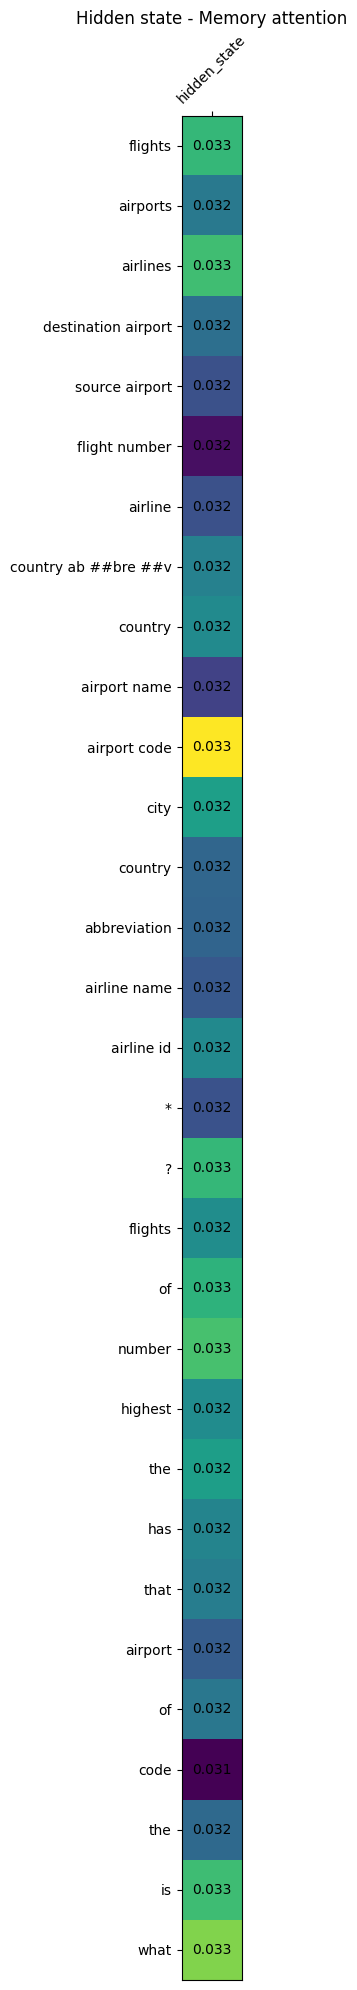

Step: 2
rule_left: agg*
choices: [1, 4, 5, 2, 3]
probs: ['89.90', '0.11', '0.10', '0.10', '0.10']


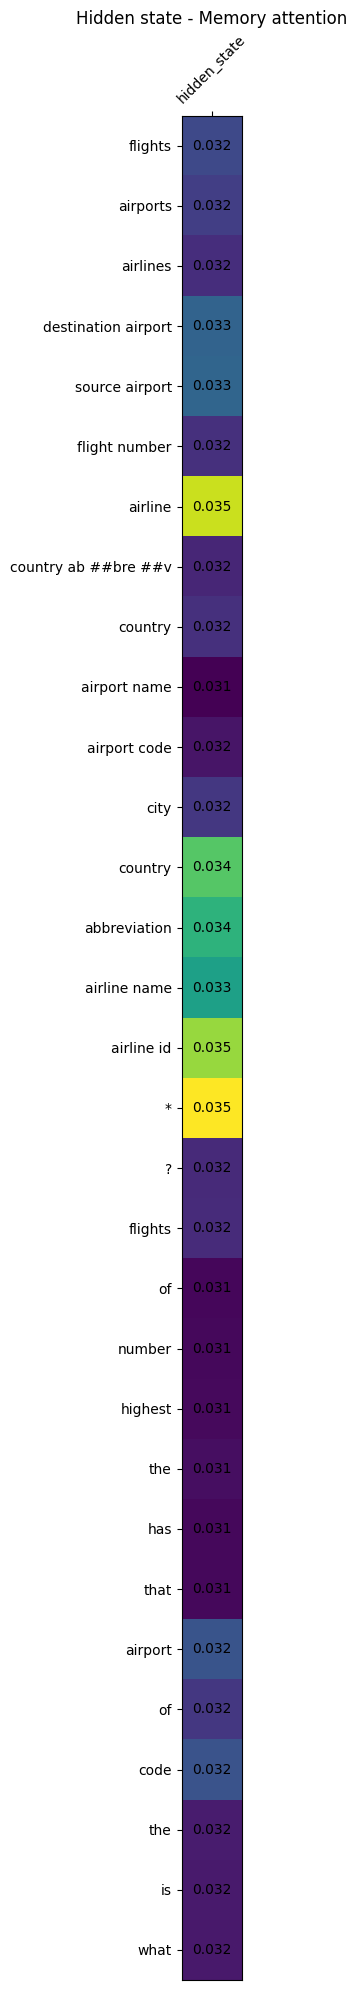

Step: 3
rule_left: agg
choices: [[True, True]]
probs: ['90.04']


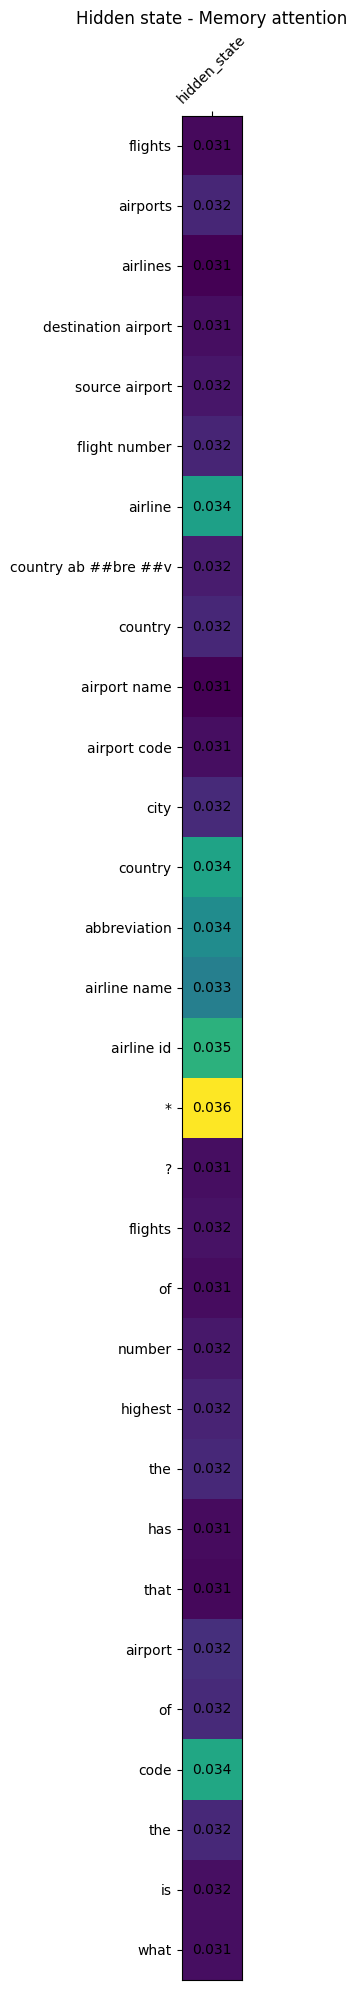

Step: 4
rule_left: agg_type
choices: ['NoneAggOp', 'Count', 'Min', 'Avg', 'Max', 'Sum']
probs: ['90.03', '0.10', '0.10', '0.10', '0.10', '0.10']


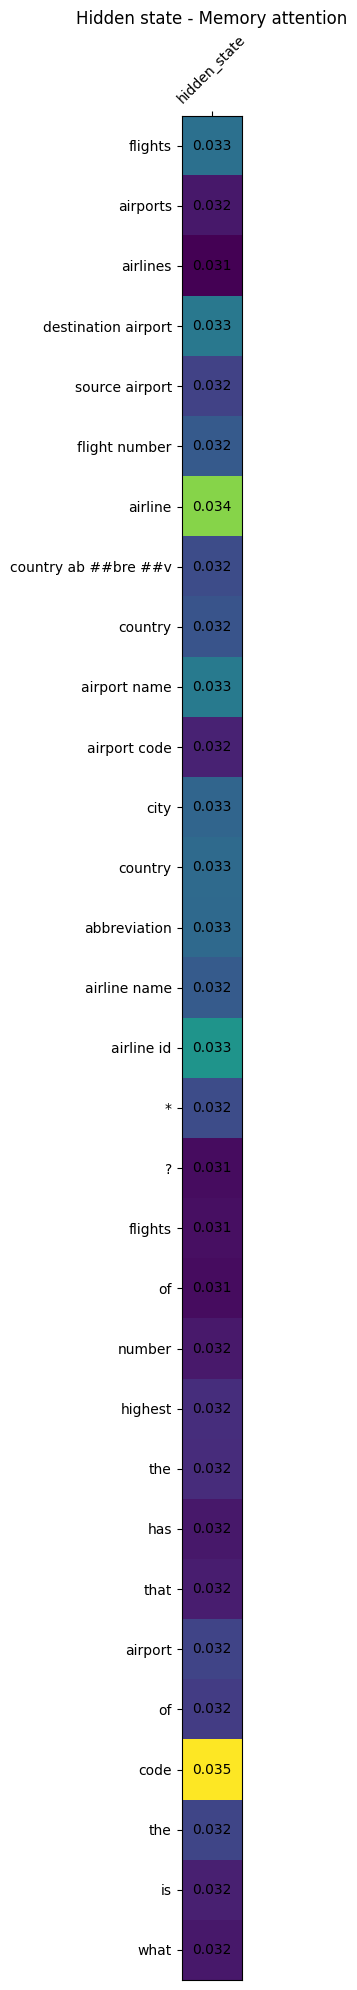

Step: 5
rule_left: val_unit
choices: ['Column', 'Divide', 'Plus', 'Minus']
probs: ['89.89', '0.11', '0.10', '0.10']


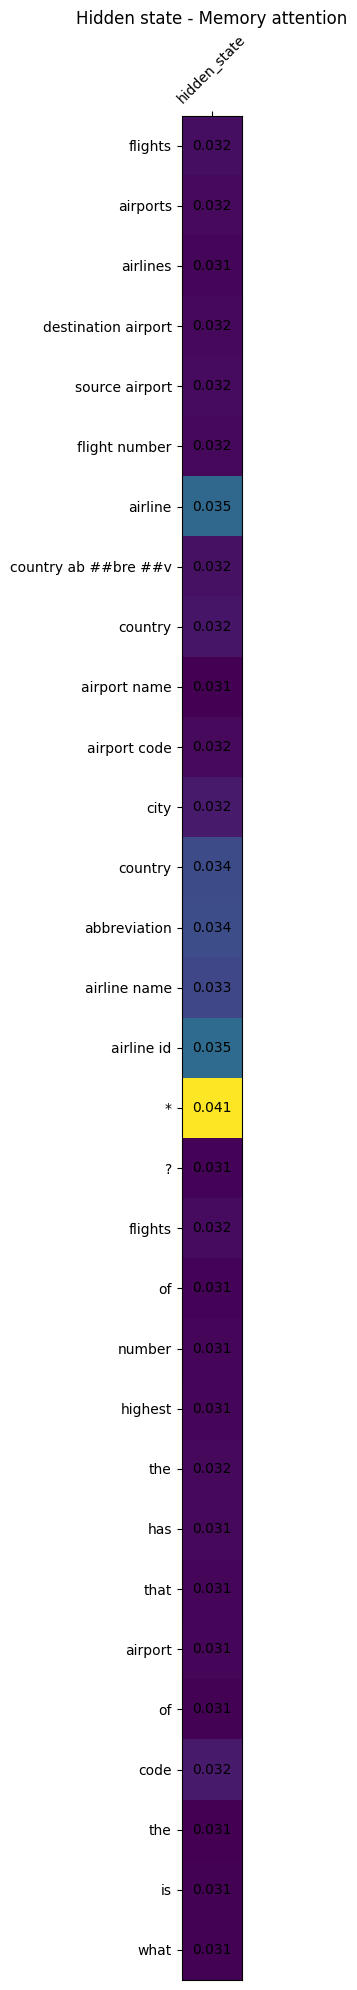

Step: 6
rule_left: Column
choices: [[True]]
probs: ['90.03']


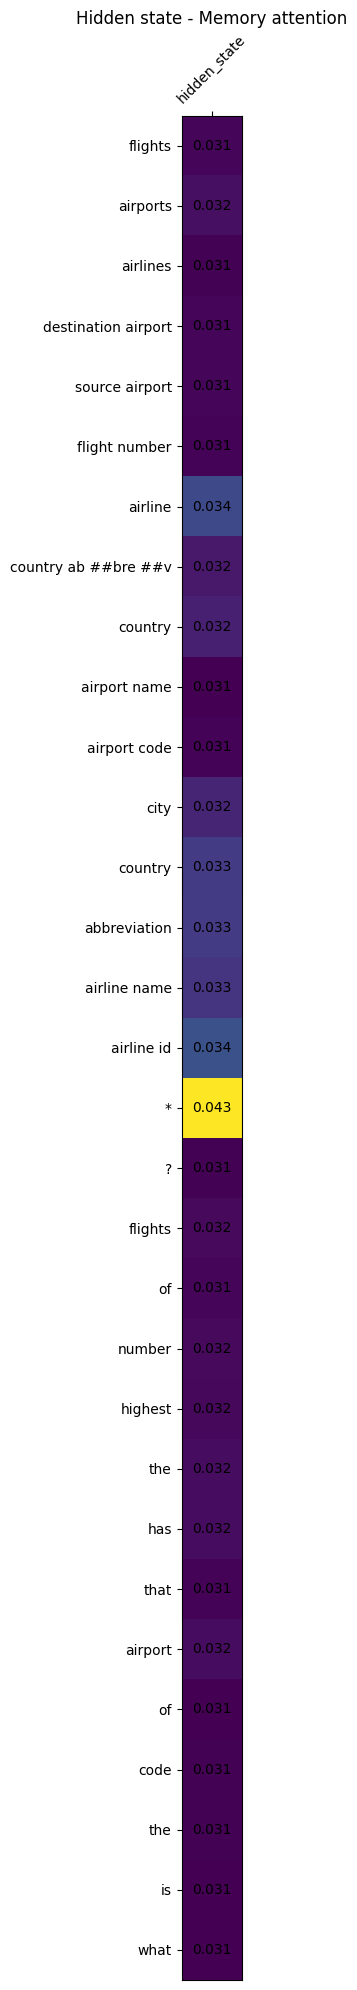

Step: 7
rule_left: col_unit
choices: [[True, 'int', 'bool']]
probs: ['90.01']


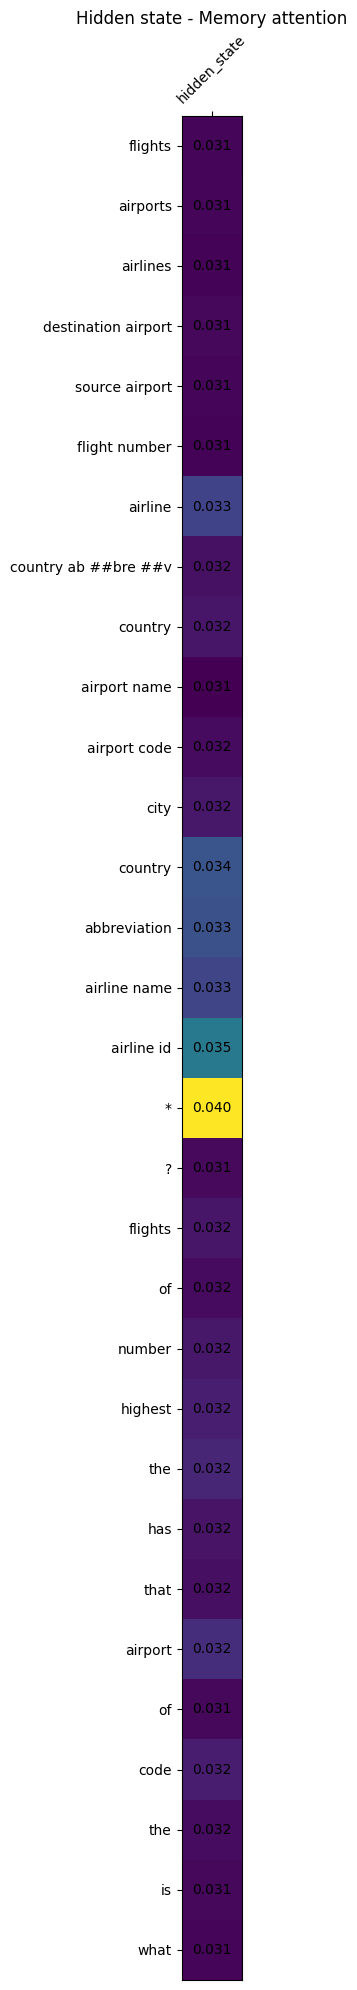

Step: 8
rule_left: agg_type
choices: ['NoneAggOp', 'Min', 'Count', 'Avg', 'Sum', 'Max']
probs: ['90.04', '0.10', '0.10', '0.10', '0.10', '0.10']


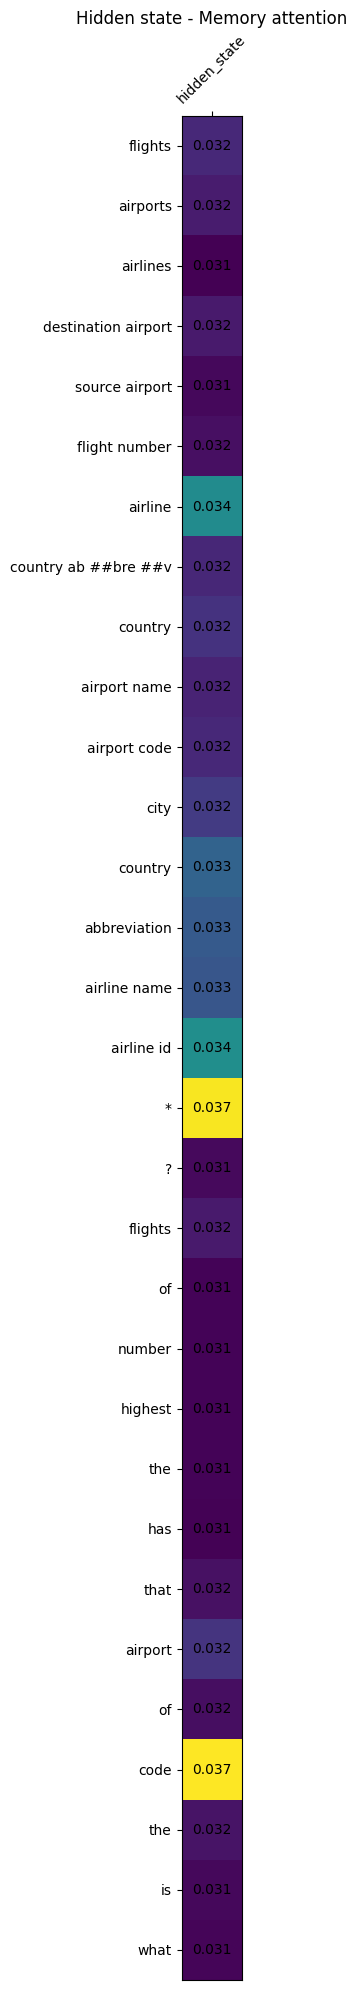

Step: 9
rule_left: column
choices: ['*', 'airline id', 'airline name', 'abbreviation', 'country', 'city', 'airport code', 'airport name', 'country', 'country ab ##bre ##v', 'airline', 'flight number', 'source airport', 'destination airport']
probs: ['0.70', '0.81', '0.87', '0.80', '0.82', '0.82', '0.66', '2.01', '0.85', '0.85', '0.84', '0.72', '0.64', '88.61']


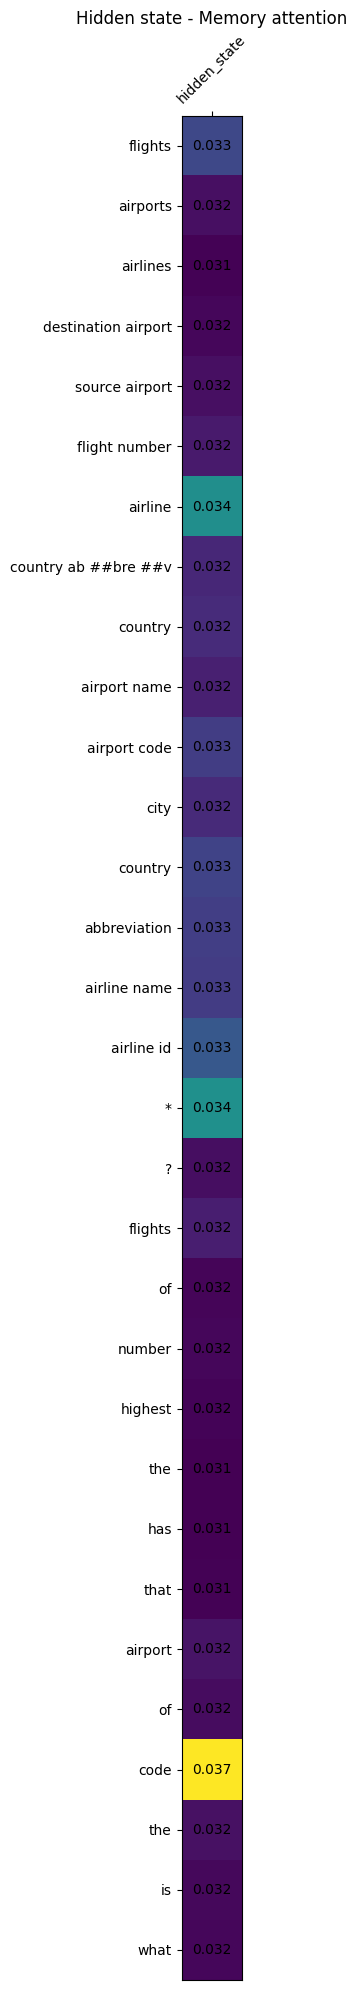

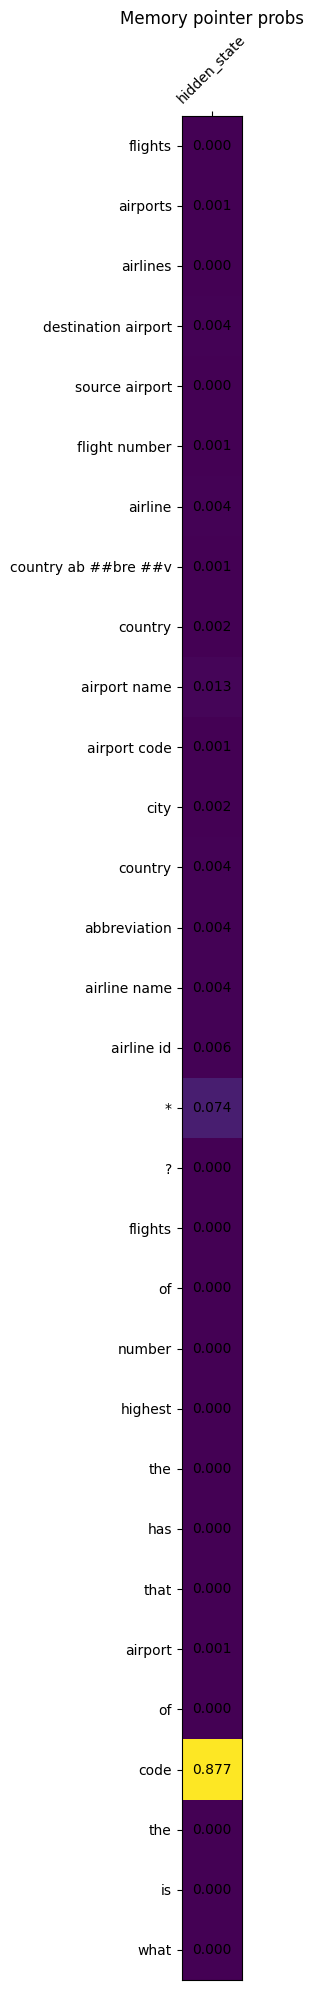

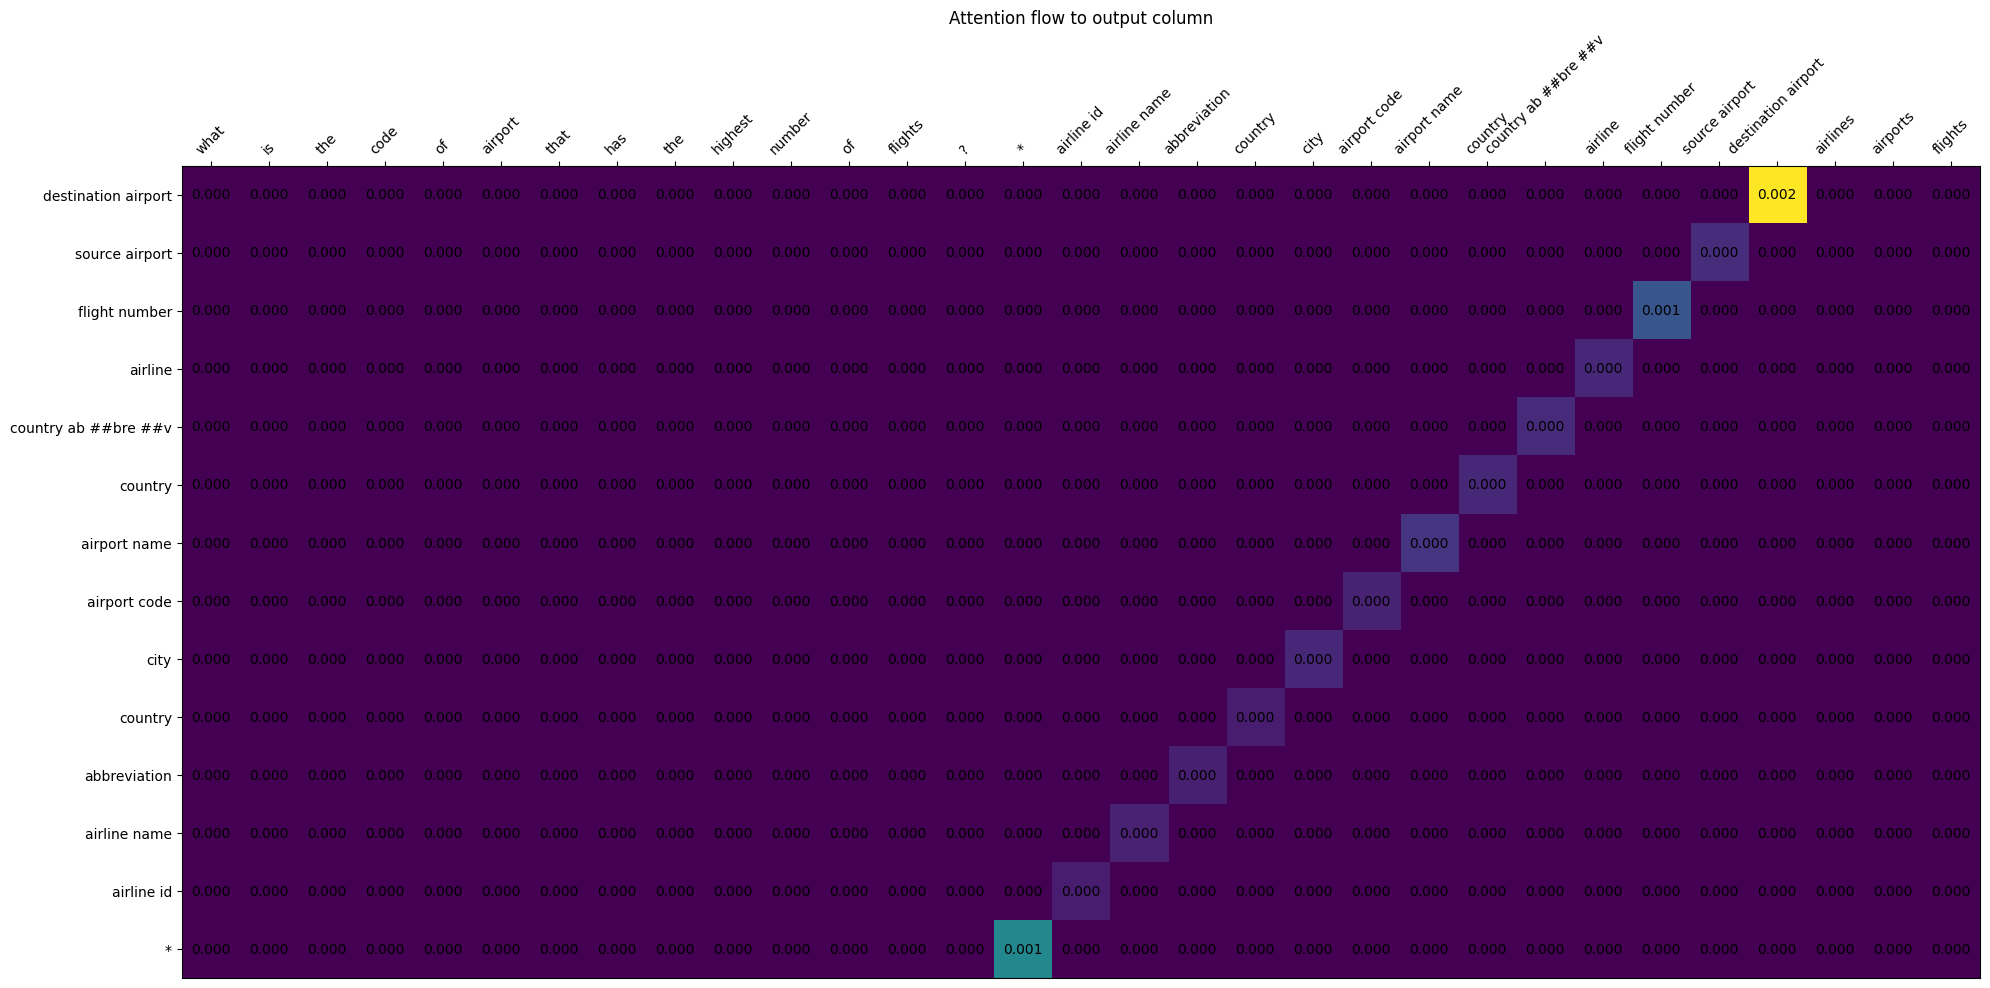

Step: 10
rule_left: sql_where
choices: [[False], [True]]
probs: ['90.40', '0.08']


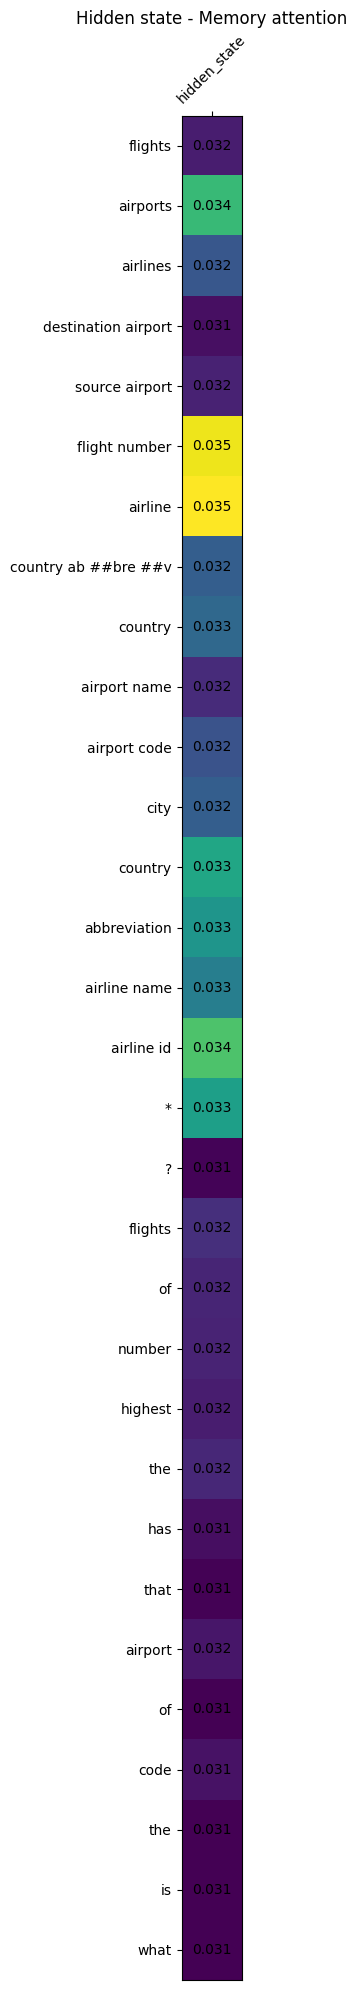

Step: 11
rule_left: sql_groupby
choices: [[True, False], [True, True], [False, False]]
probs: ['90.53', '0.10', '0.09']


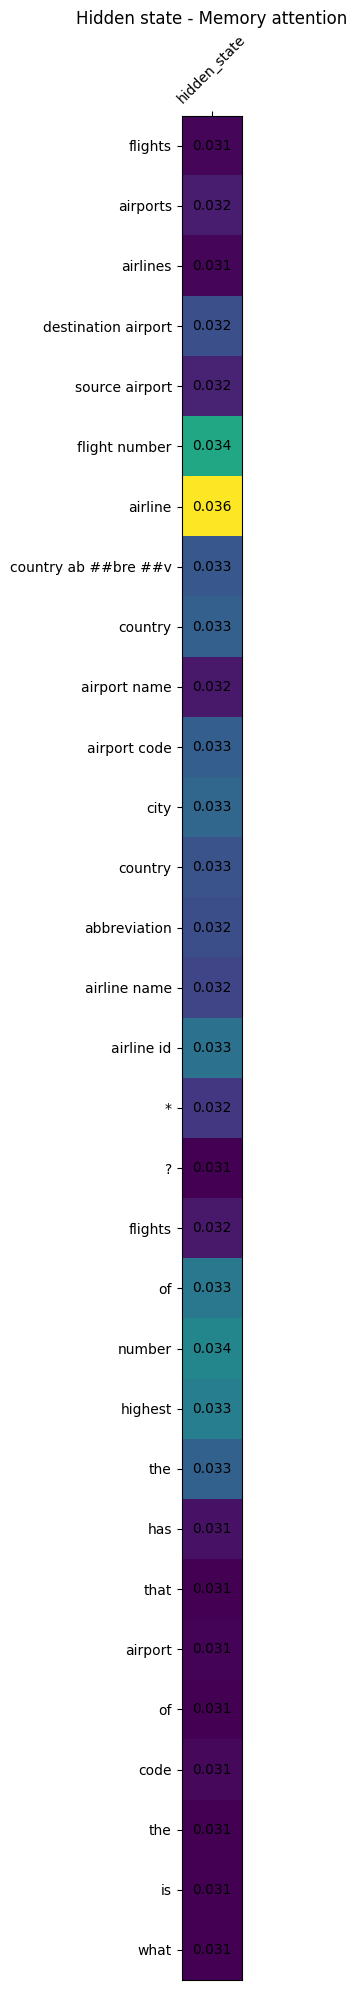

Step: 12
rule_left: col_unit*
choices: [1, 3, 2, 0]
probs: ['90.29', '0.11', '0.10', '0.10']


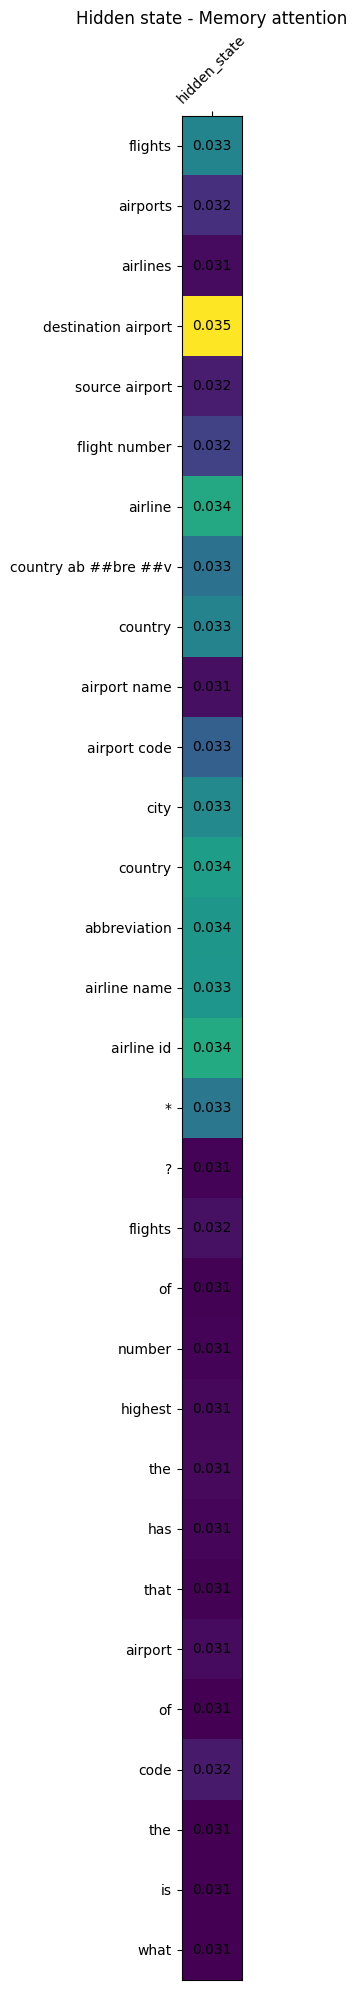

Step: 13
rule_left: col_unit
choices: [[True, 'int', 'bool']]
probs: ['90.03']


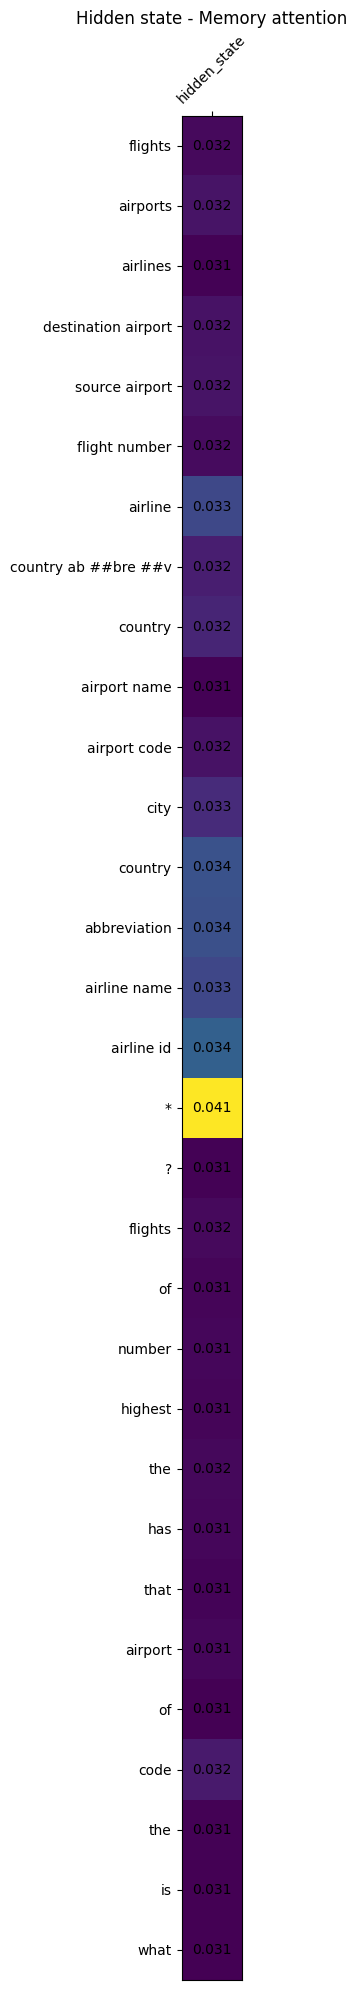

Step: 14
rule_left: agg_type
choices: ['NoneAggOp', 'Count', 'Min', 'Avg', 'Max', 'Sum']
probs: ['89.95', '0.11', '0.10', '0.10', '0.10', '0.10']


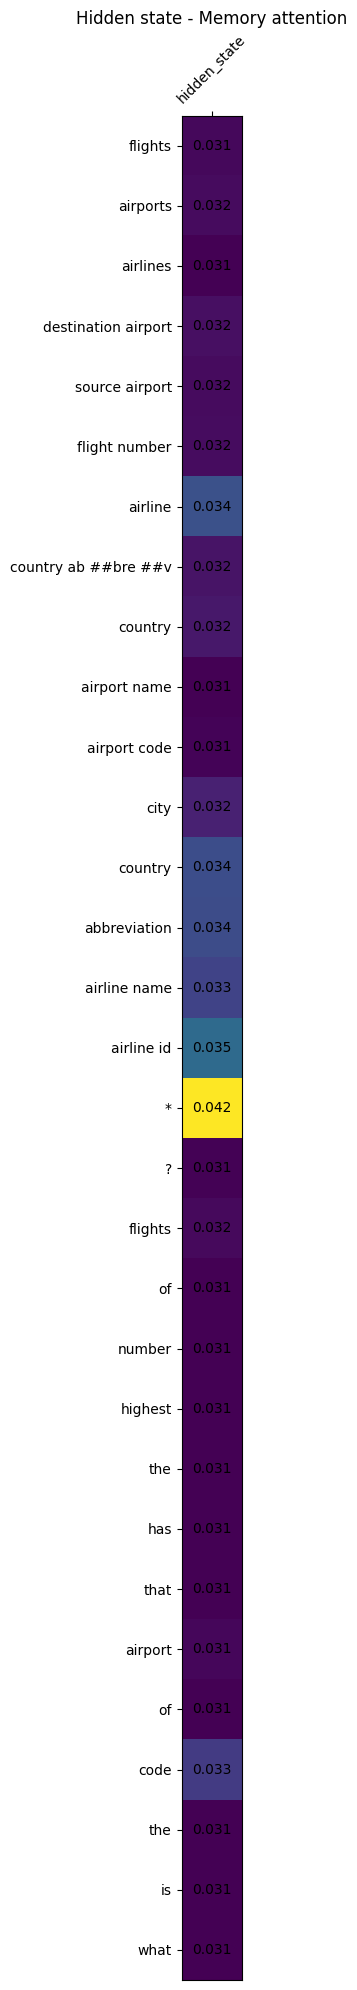

Step: 15
rule_left: column
choices: ['*', 'airline id', 'airline name', 'abbreviation', 'country', 'city', 'airport code', 'airport name', 'country', 'country ab ##bre ##v', 'airline', 'flight number', 'source airport', 'destination airport']
probs: ['0.96', '1.03', '1.11', '1.03', '1.05', '1.00', '0.77', '0.88', '1.02', '1.01', '1.08', '0.86', '1.30', '86.88']


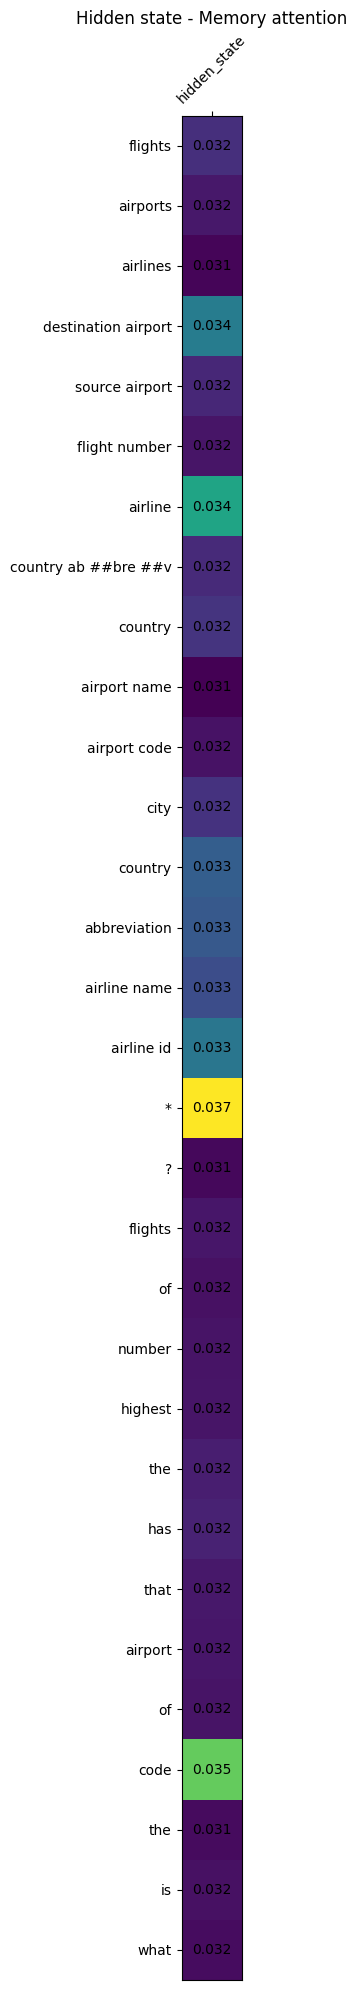

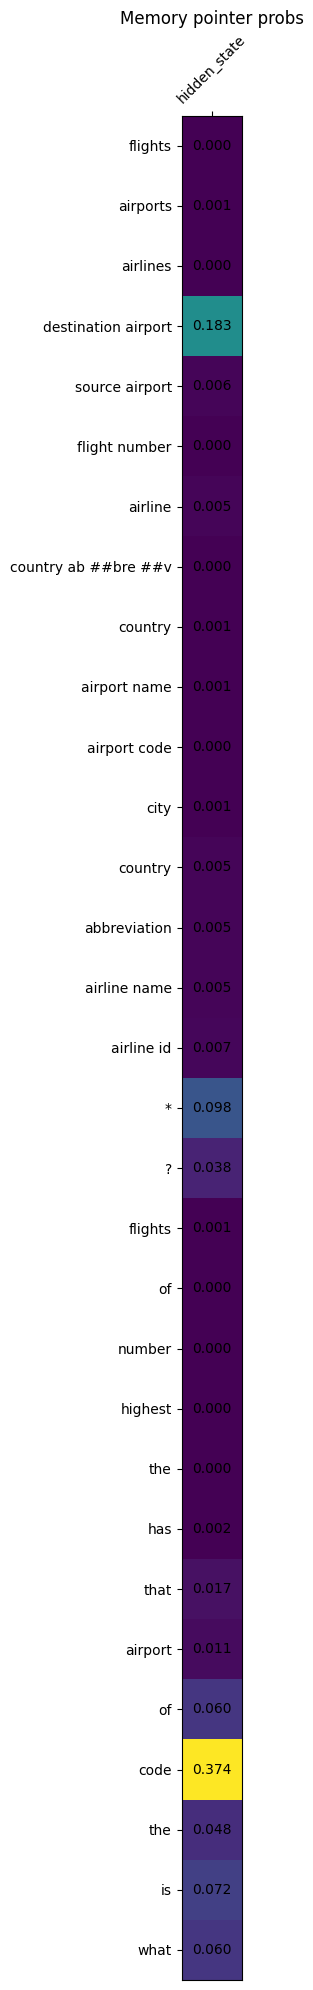

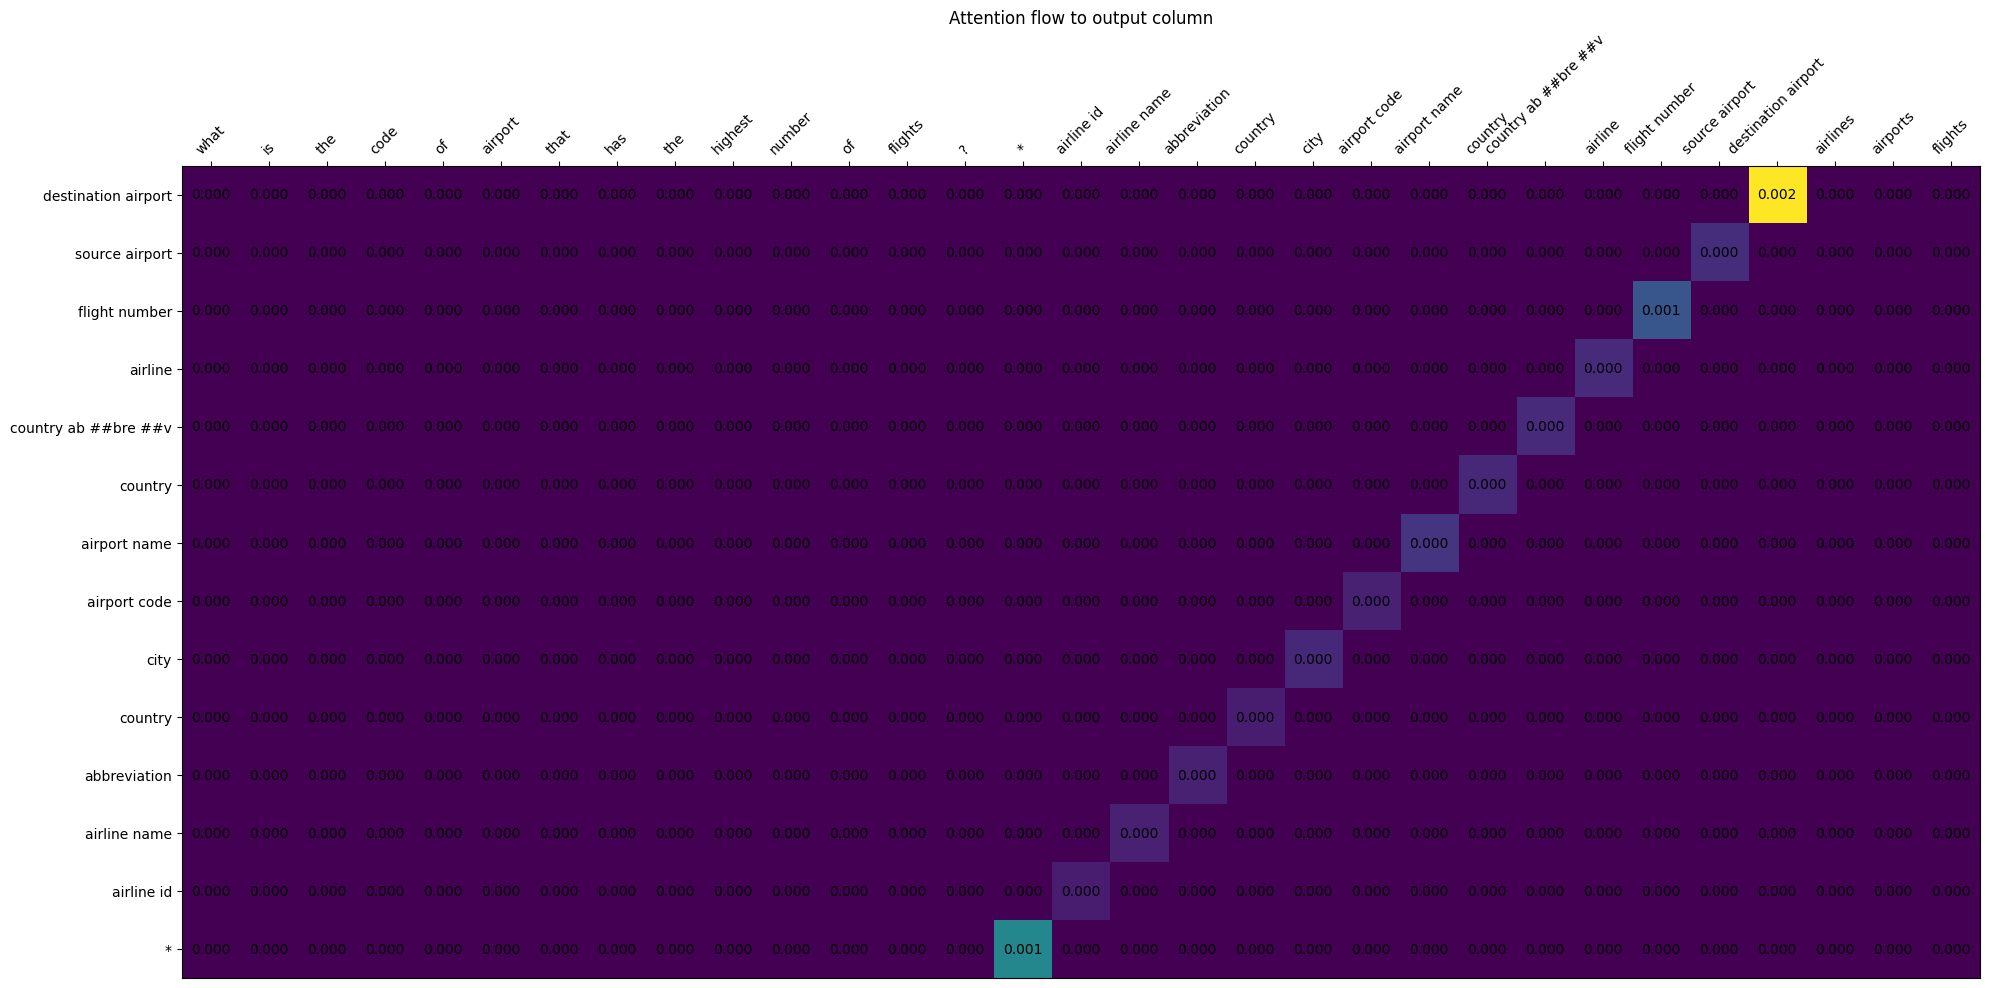

Step: 16
rule_left: sql_orderby
choices: [[True, 'bool'], [False, 'bool']]
probs: ['89.91', '0.11']


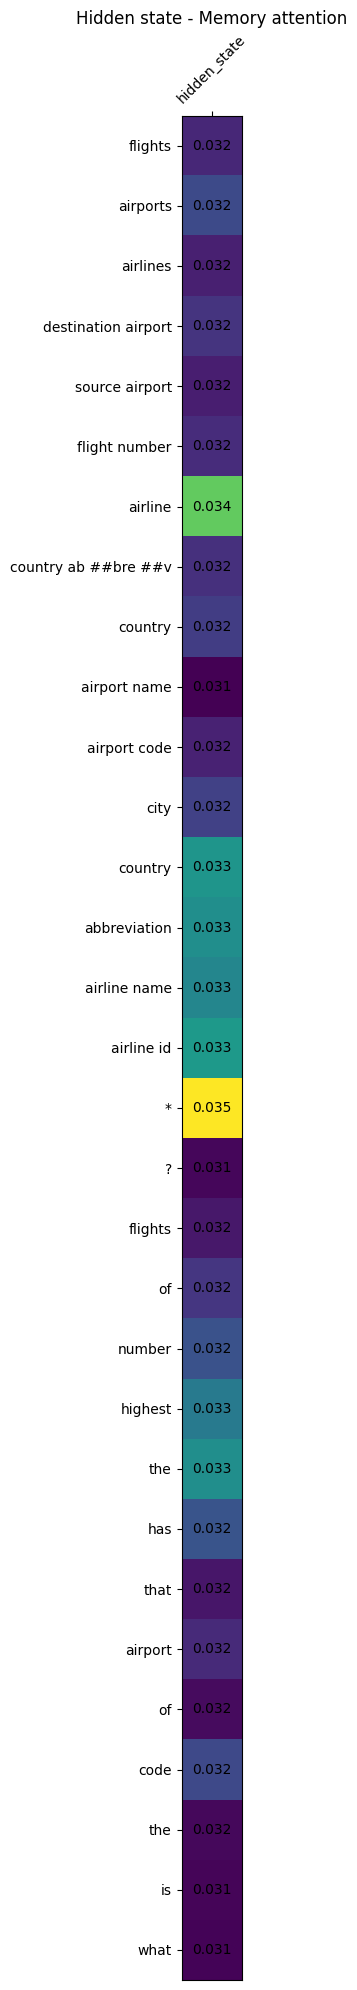

Step: 17
rule_left: order_by
choices: [[True, True]]
probs: ['89.93']


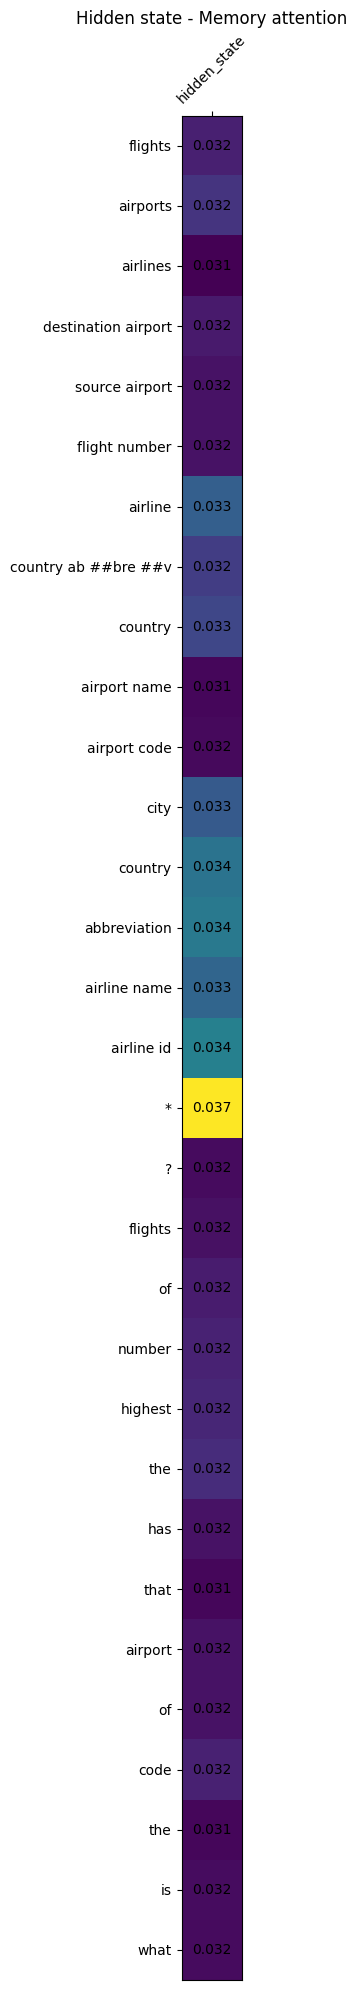

Step: 18
rule_left: order
choices: ['Desc', 'Asc']
probs: ['90.06', '0.09']


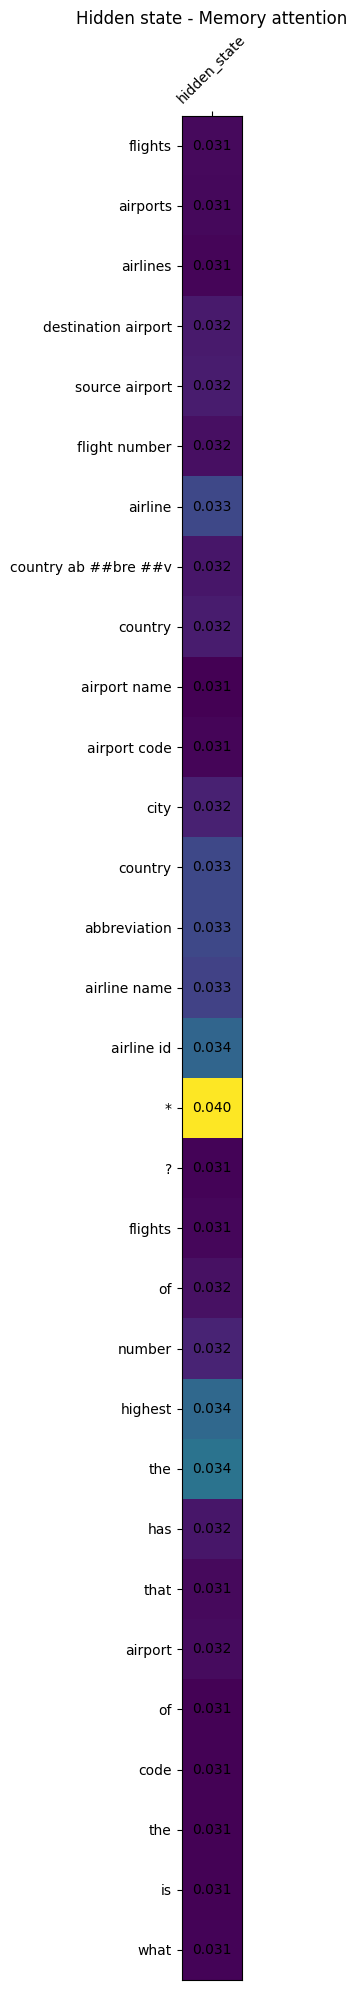

Step: 19
rule_left: val_unit*
choices: [1, 3, 2]
probs: ['90.42', '0.12', '0.09']


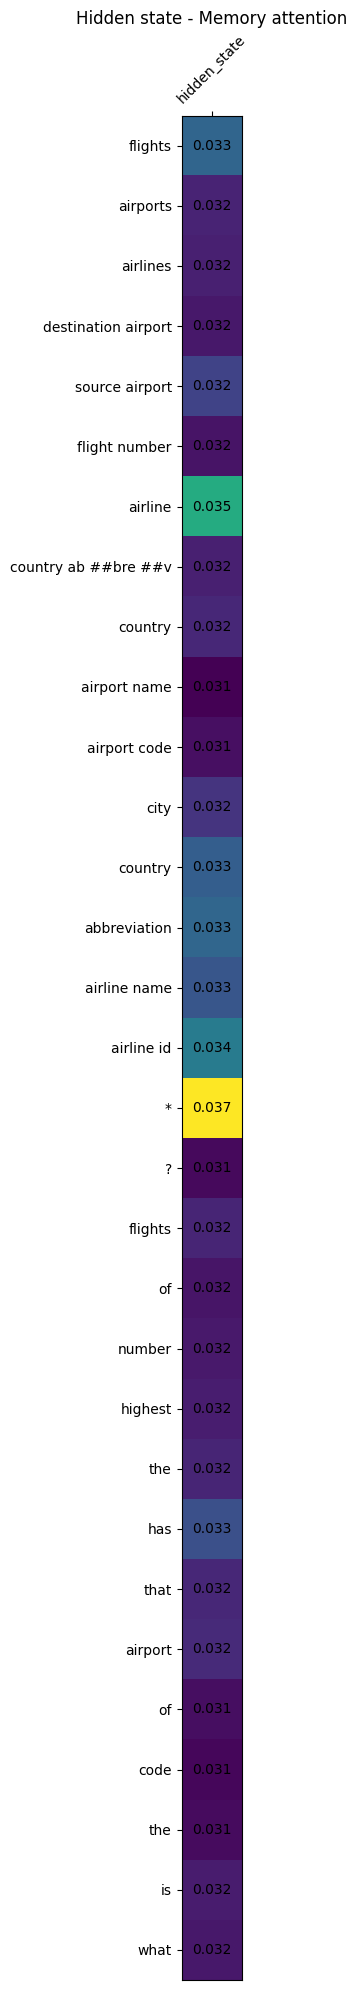

Step: 20
rule_left: val_unit_seq_elem
choices: ['Column', 'Plus', 'Minus']
probs: ['90.05', '0.10', '0.10']


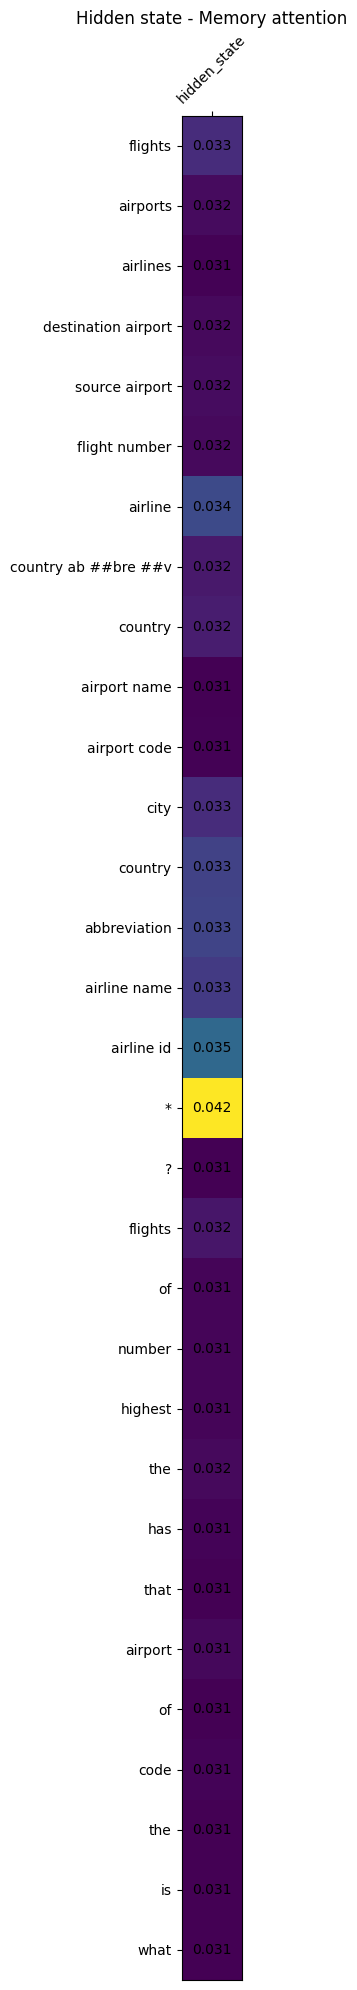

Step: 21
rule_left: Column
choices: [[True]]
probs: ['90.01']


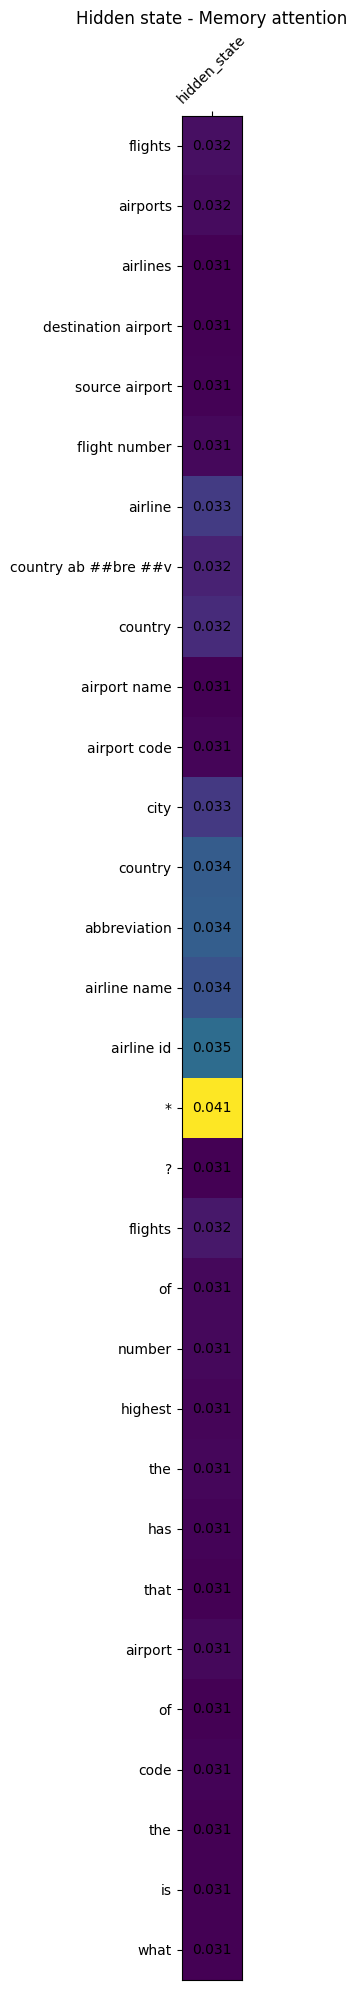

Step: 22
rule_left: col_unit
choices: [[True, 'int', 'bool']]
probs: ['89.97']


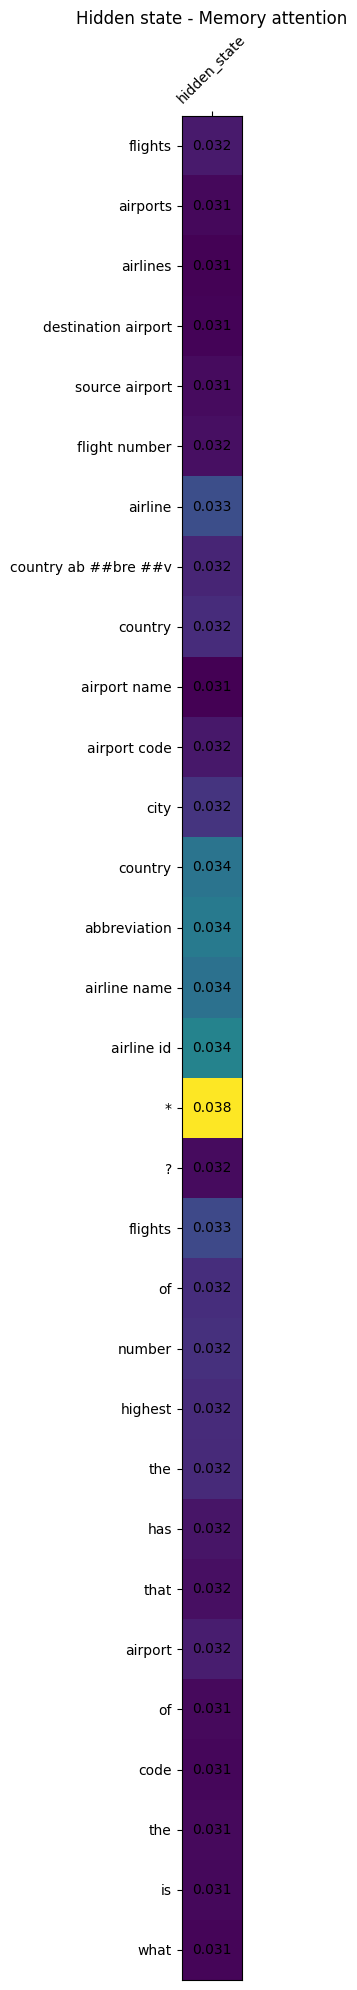

Step: 23
rule_left: agg_type
choices: ['Count', 'NoneAggOp', 'Min', 'Max', 'Avg', 'Sum']
probs: ['90.02', '0.11', '0.10', '0.10', '0.10', '0.10']


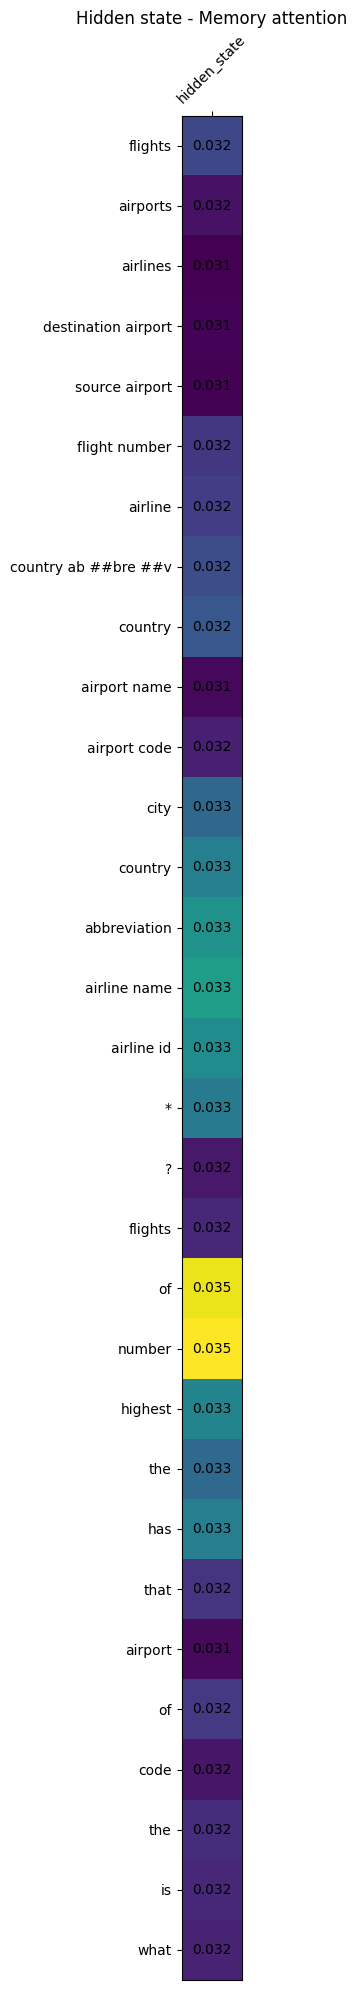

Step: 24
rule_left: column
choices: ['*', 'airline id', 'airline name', 'abbreviation', 'country', 'city', 'airport code', 'airport name', 'country', 'country ab ##bre ##v', 'airline', 'flight number', 'source airport', 'destination airport']
probs: ['95.38', '0.39', '0.42', '0.38', '0.39', '0.39', '0.28', '0.28', '0.39', '0.39', '0.39', '0.34', '0.28', '0.30']


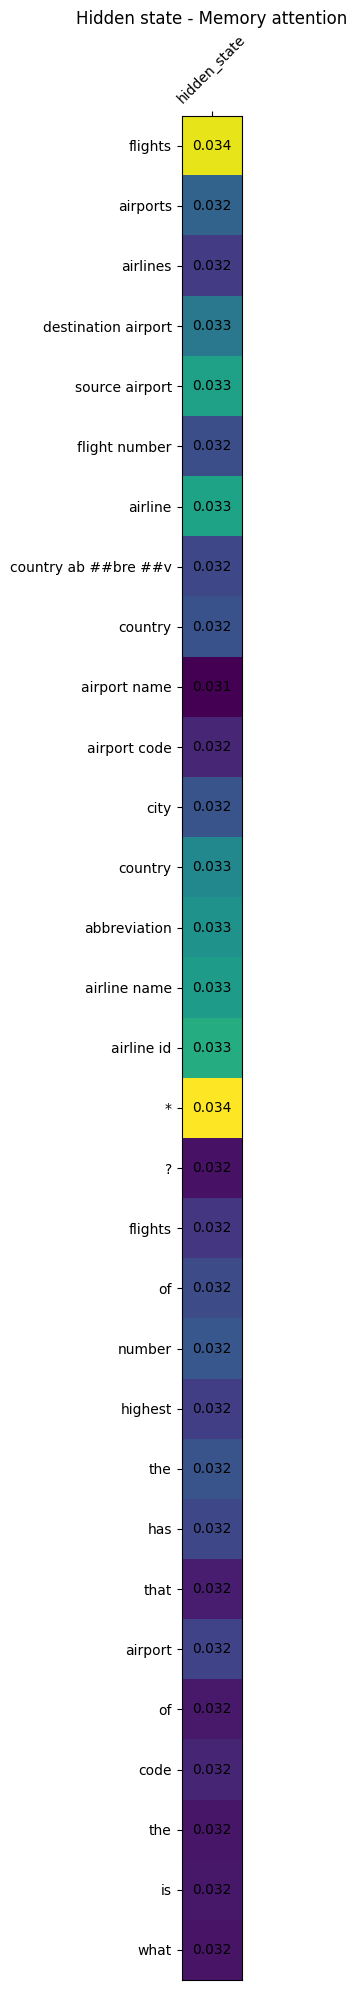

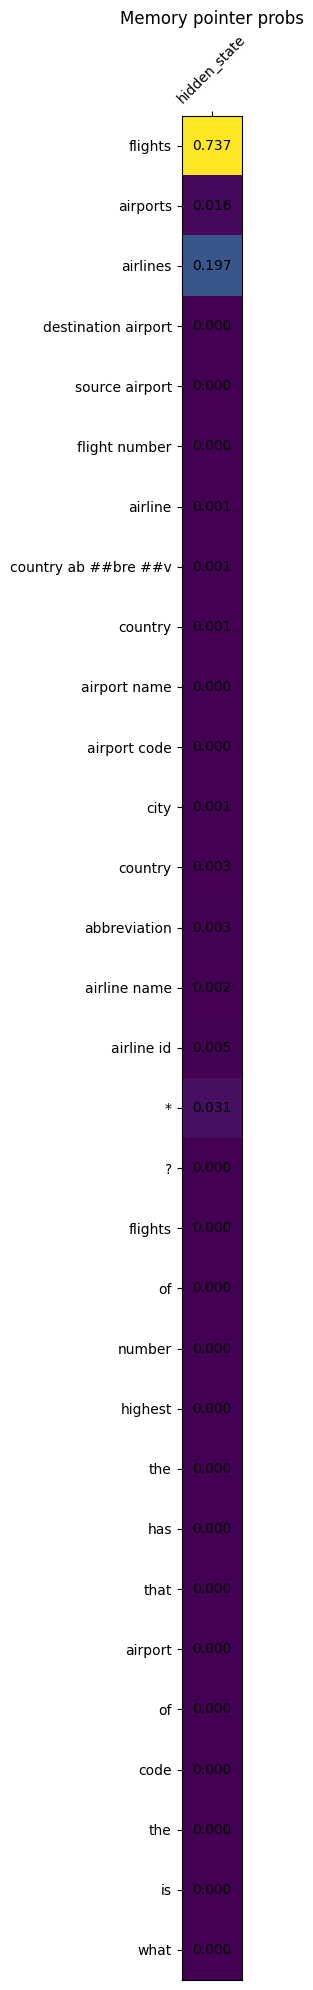

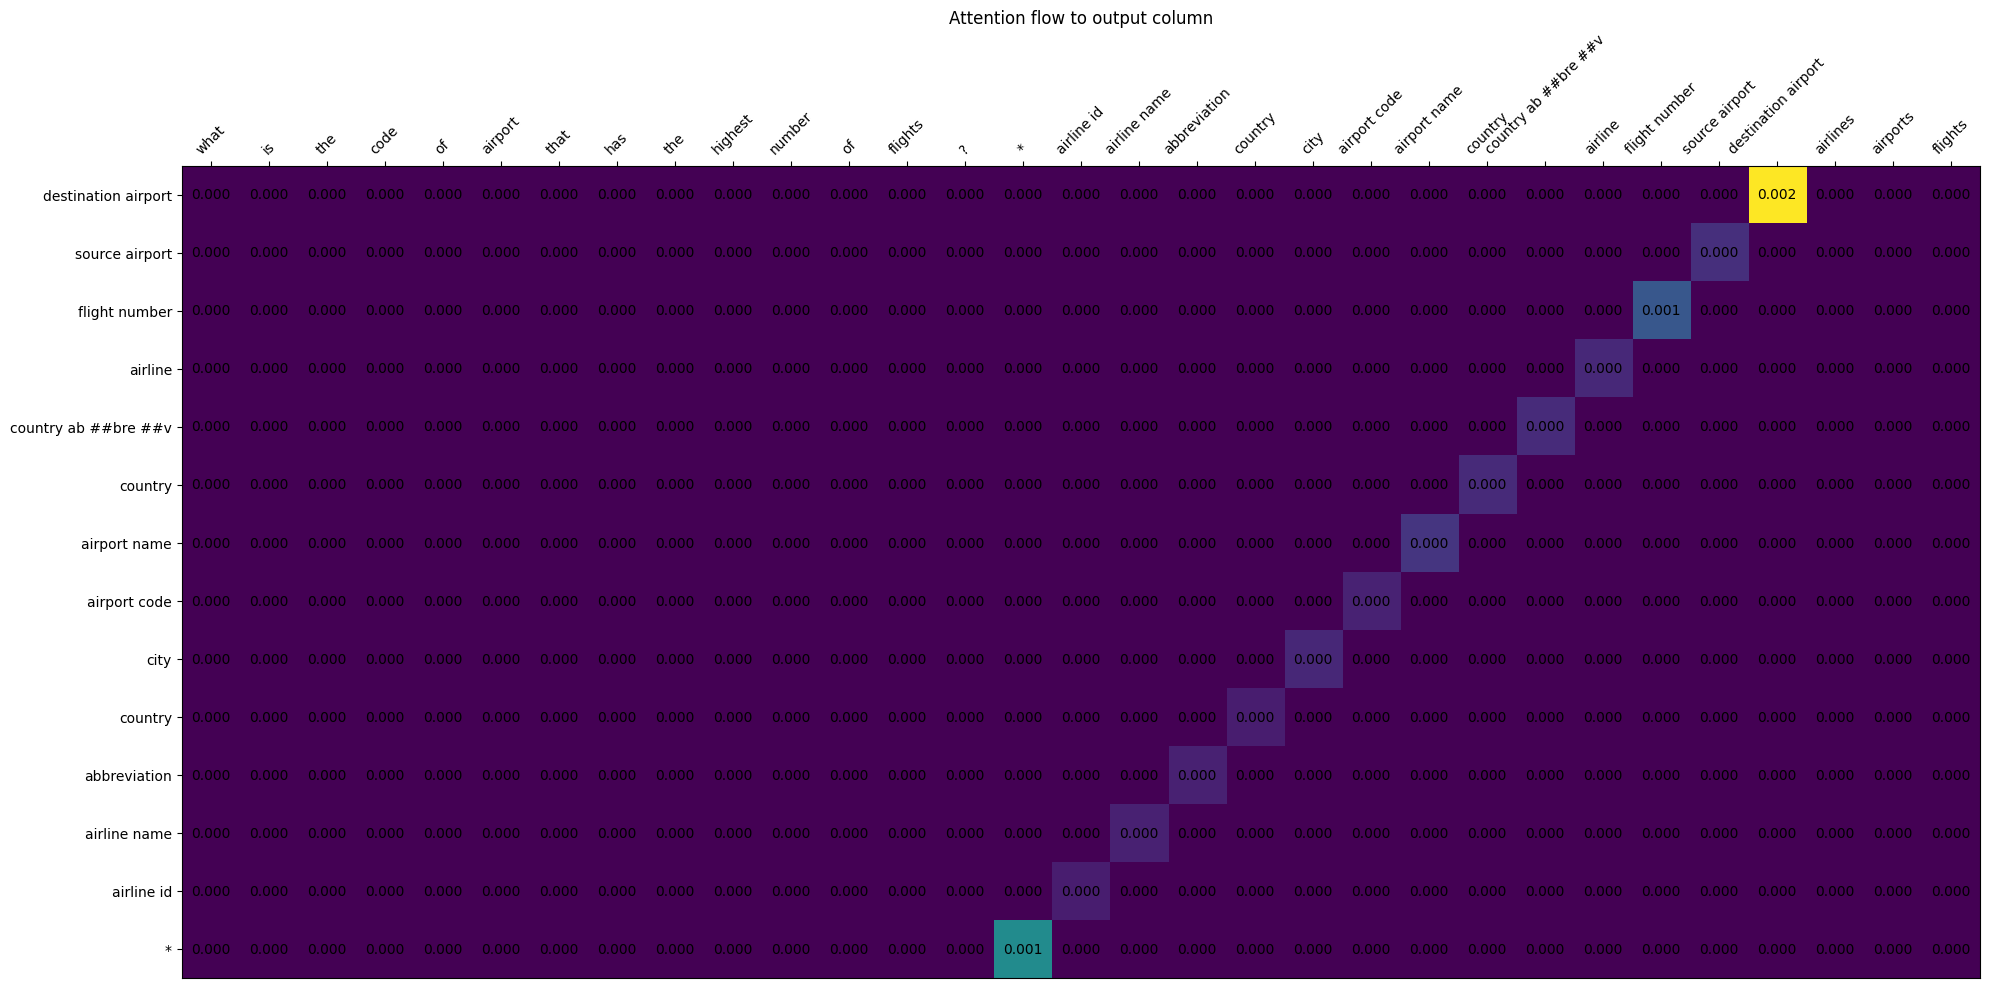

Step: 25
rule_left: sql_ieu
choices: [[False, False, False], [False, True, False], [True, False, False], [False, False, True]]
probs: ['89.95', '0.11', '0.10', '0.10']


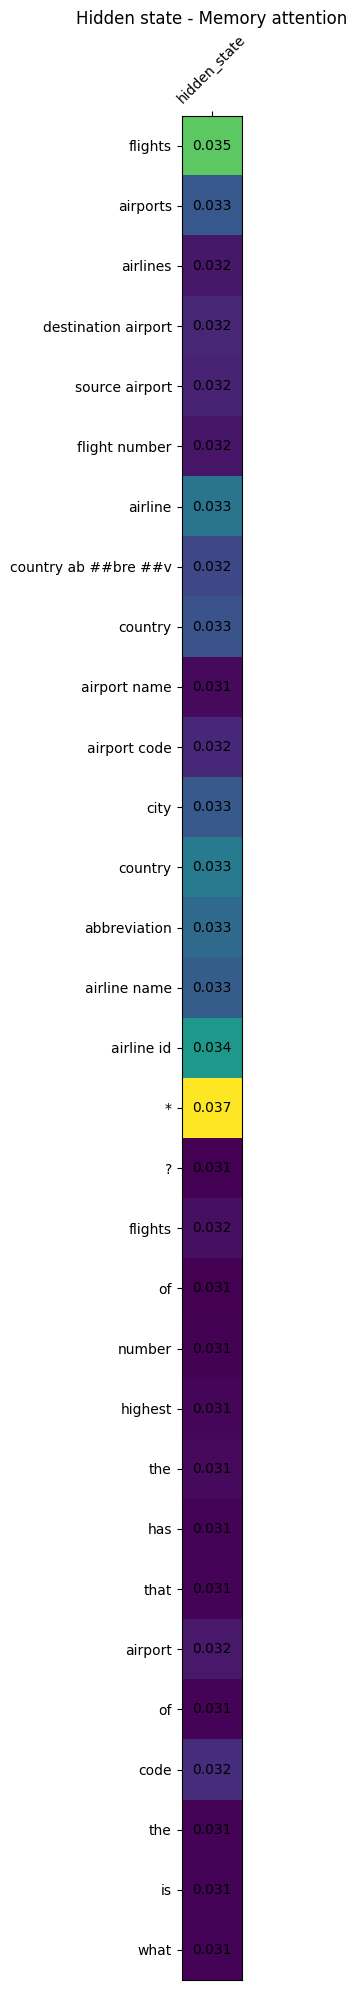

Step: 26
rule_left: from
choices: [[True, False]]
probs: ['90.05']


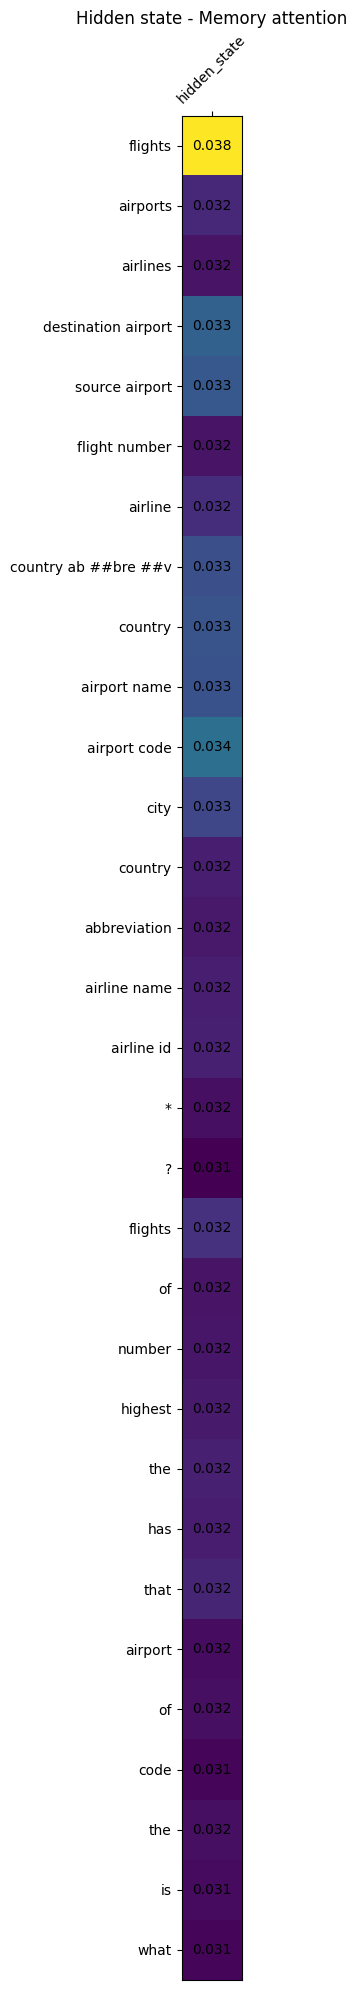

Step: 27
rule_left: table_unit*
choices: [1, 2, 5, 3, 6, 7, 4]
probs: ['87.79', '3.85', '0.23', '0.19', '0.09', '0.08', '0.08']


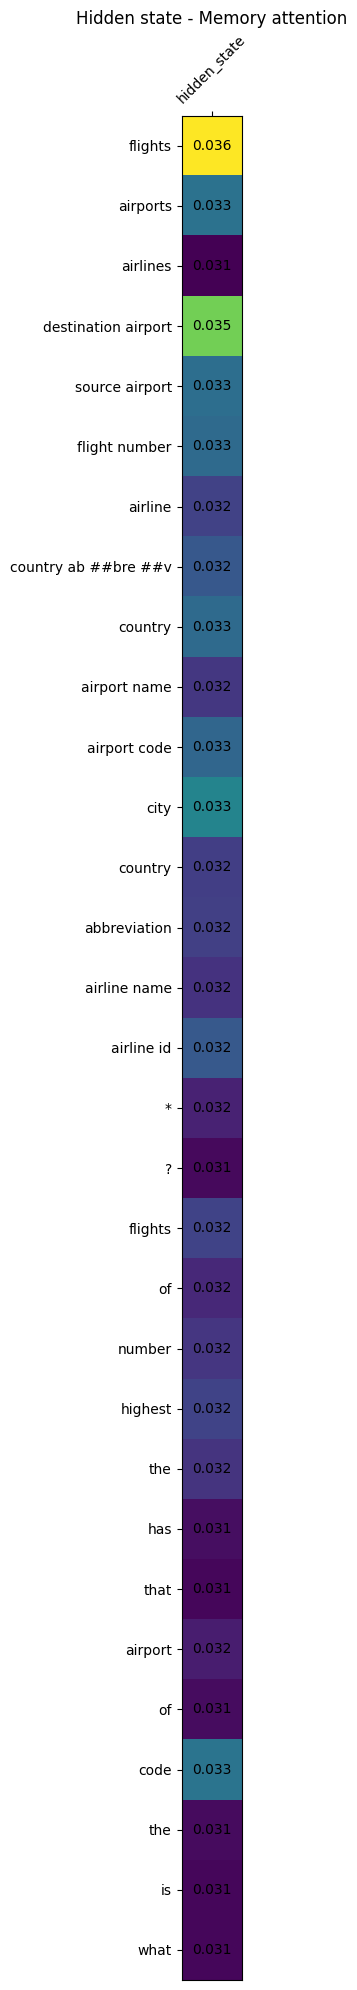

Step: 28
rule_left: table_unit_seq_elem
choices: ['Table', 'TableUnitSql']
probs: ['90.14', '0.11']


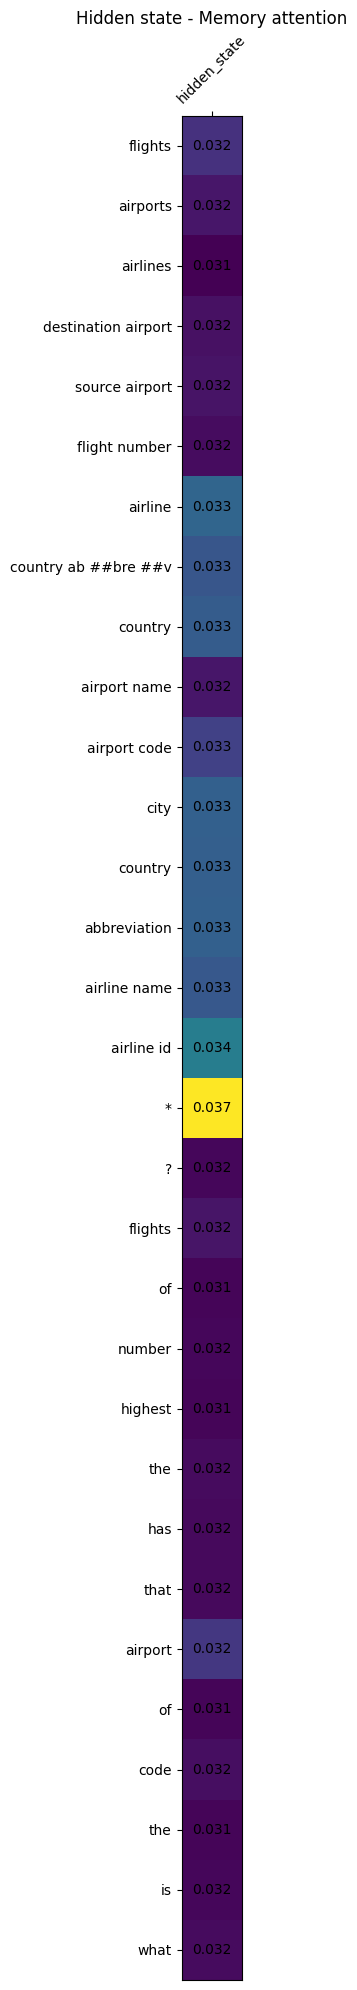

Step: 29
rule_left: Table
choices: [['int']]
probs: ['90.10']


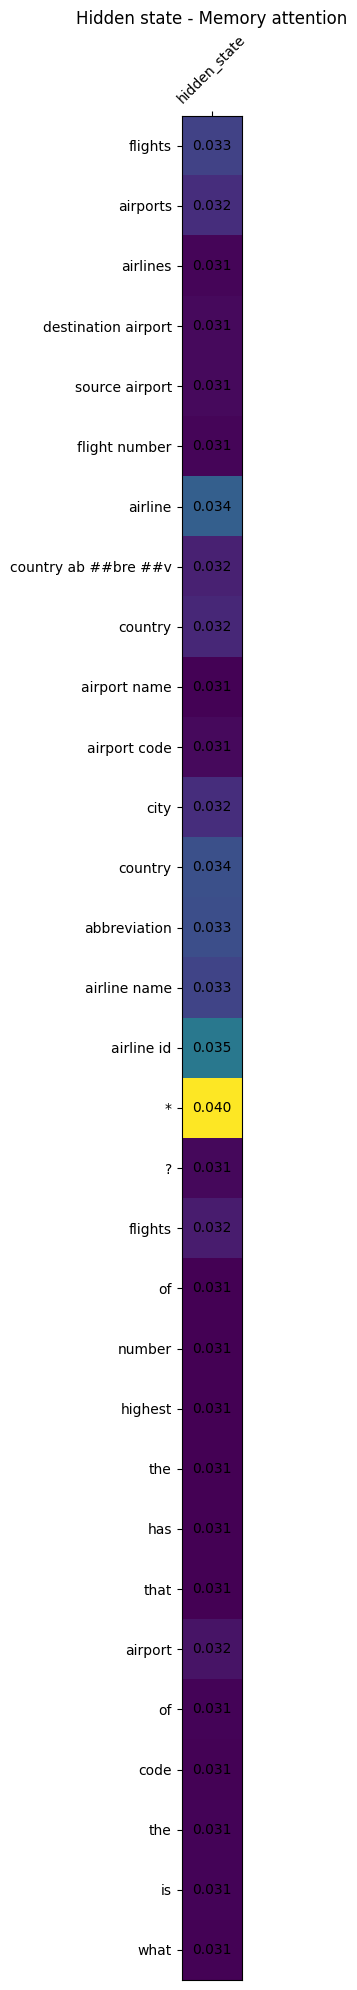

Step: 30
rule_left: table
choices: [['airlines'], ['airports'], ['flights']]
probs: ['5.06', '87.40', '7.54']


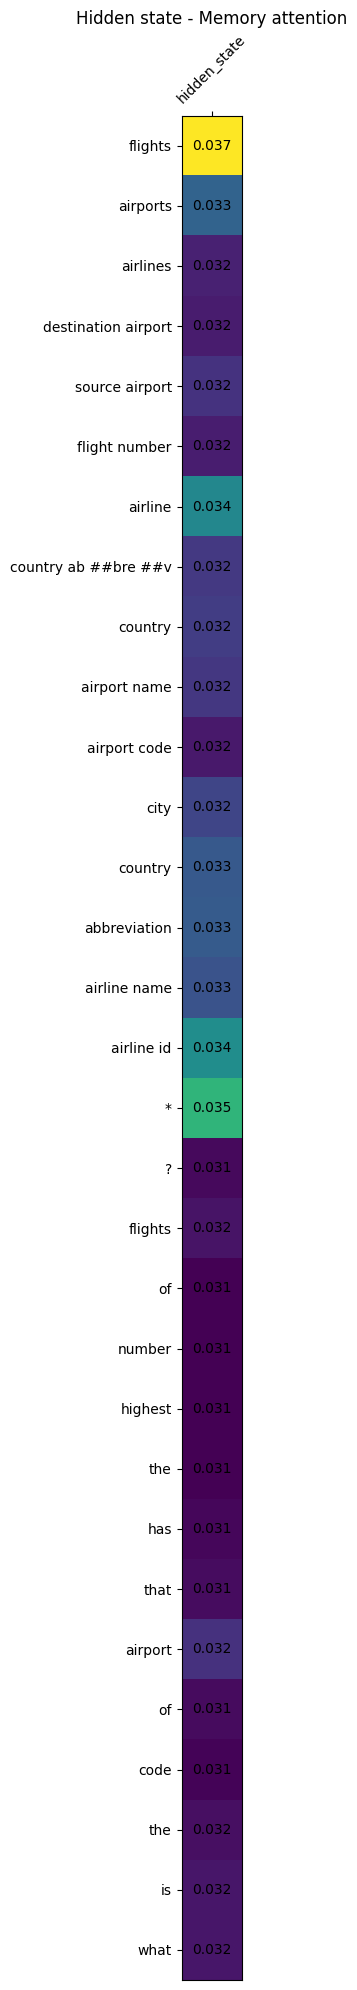

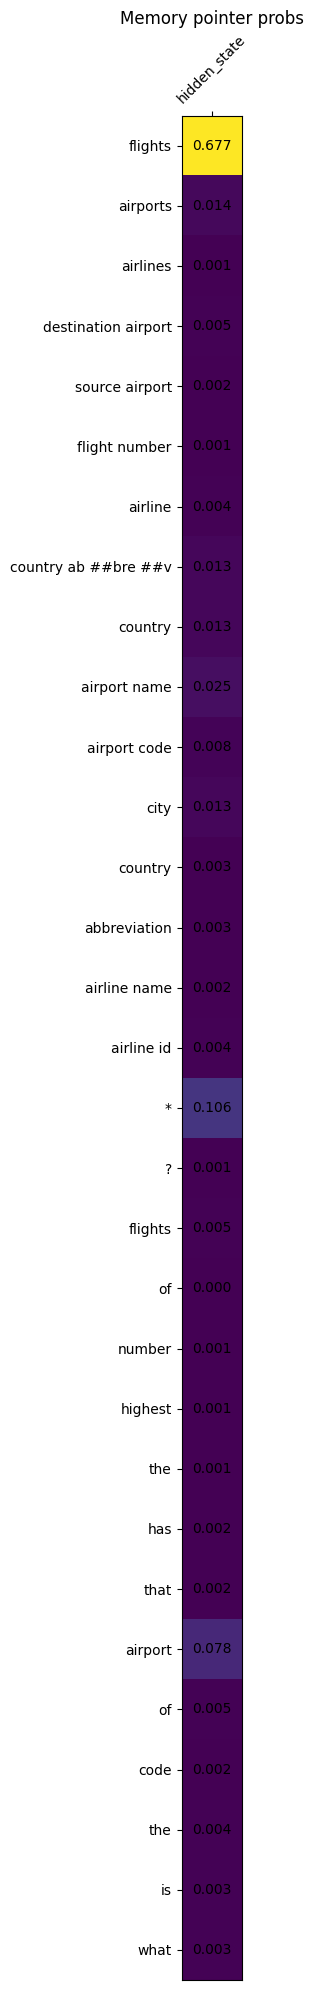

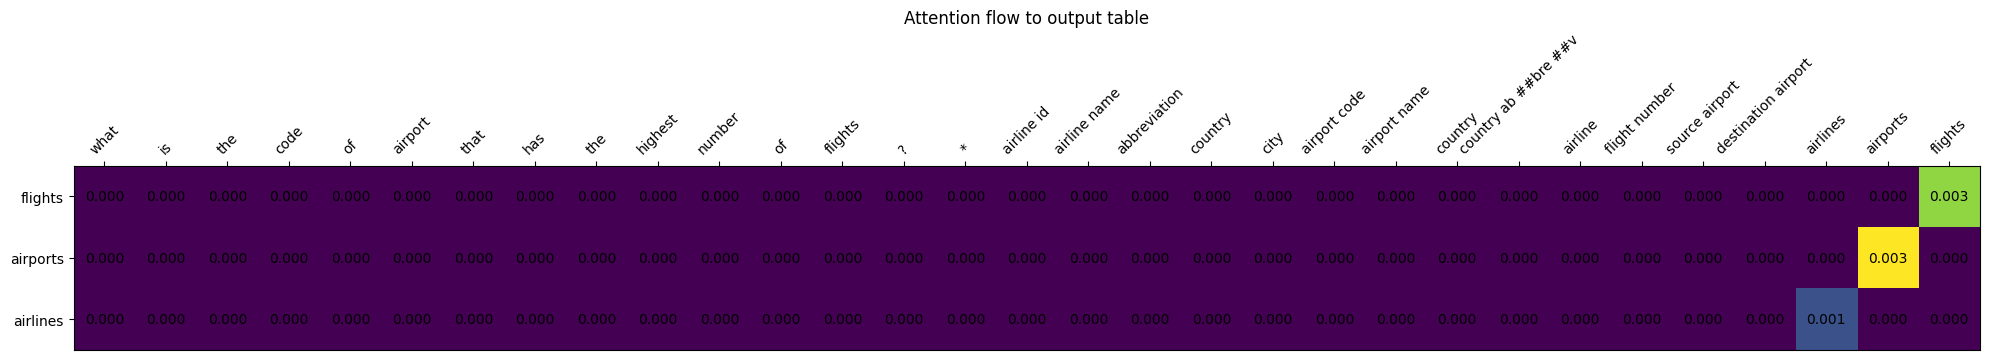

Step: 31
rule_left: table_unit_seq_elem
choices: ['Table', 'TableUnitSql']
probs: ['90.09', '0.11']


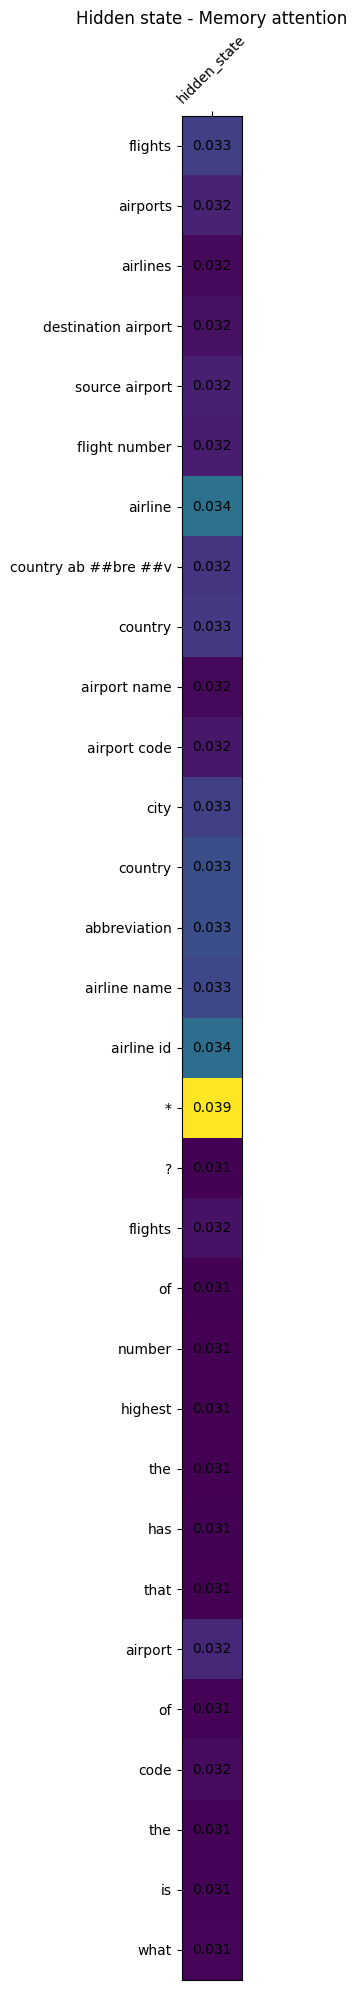

Step: 32
rule_left: Table
choices: [['int']]
probs: ['90.05']


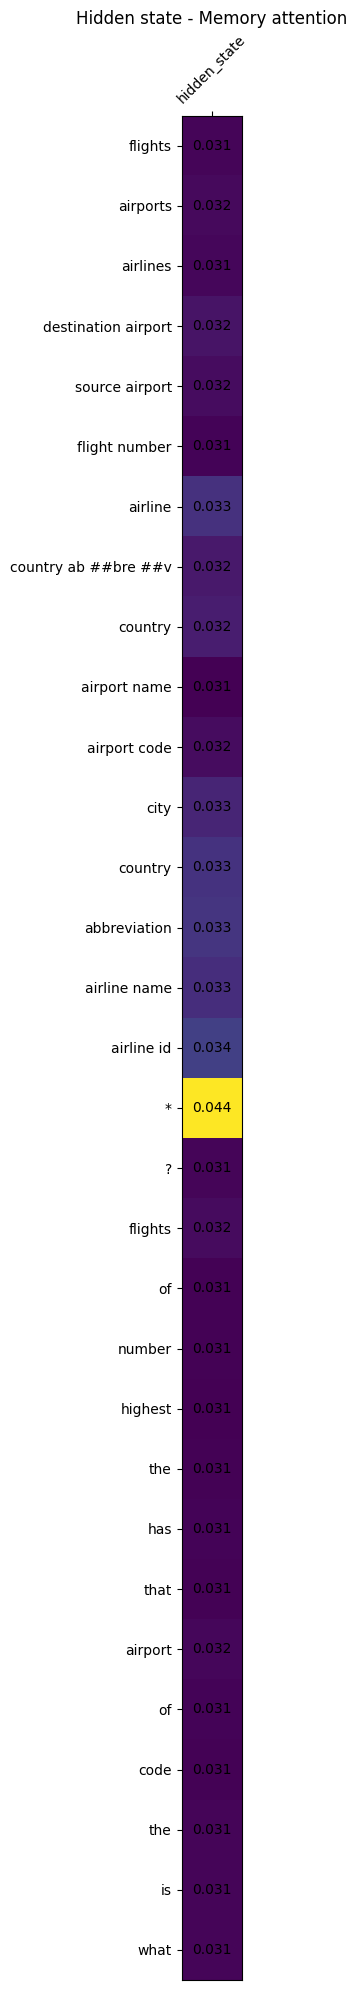

Step: 33
rule_left: table
choices: [['airlines'], ['airports'], ['flights']]
probs: ['4.01', '3.72', '92.27']


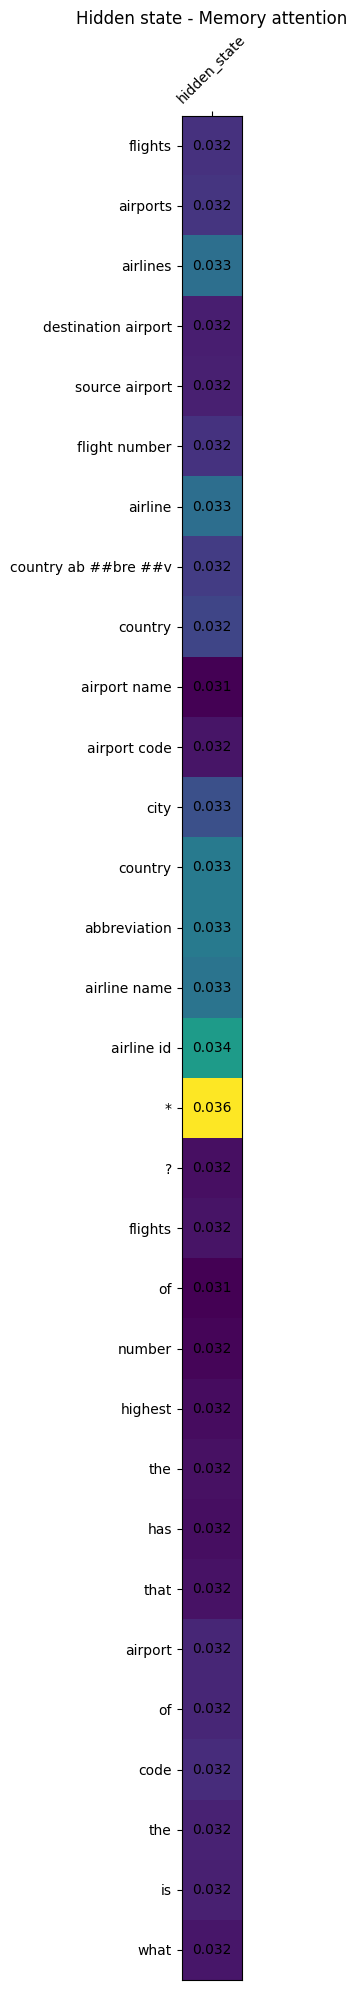

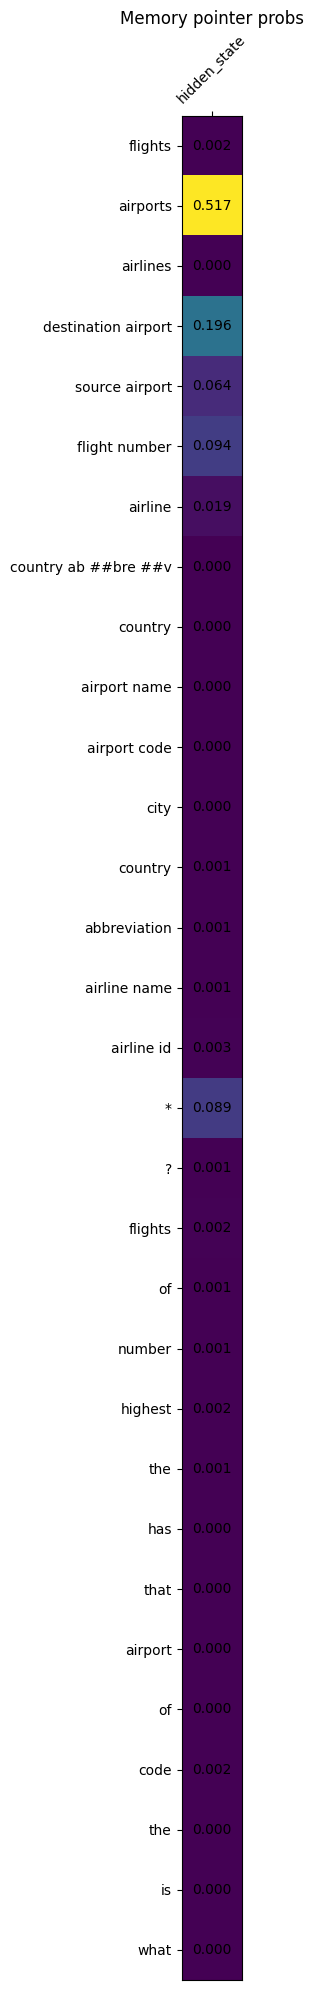

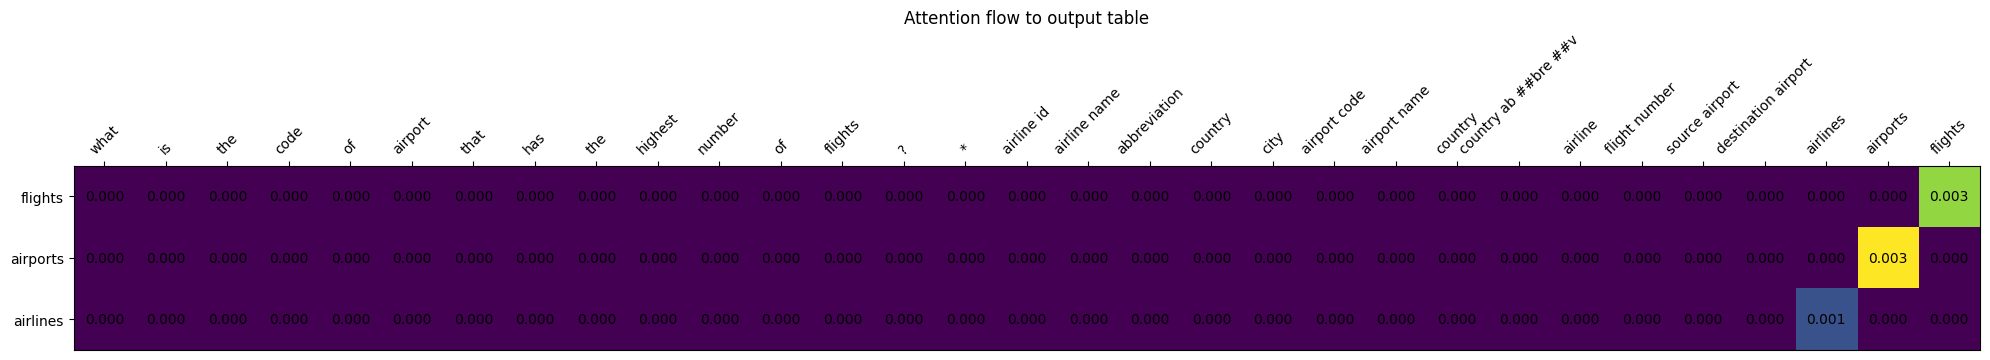

In [11]:
# Do analysis
api(wrong_indices, eval_list, debug_list, infer_list, model_idx=2, item_idx=225)

In [12]:
warnings.filterwarnings('ignore')
# Load trained models
model_seeds = [0, 2, 3]
model_type='electra'
trained_models = [load_model(seed, model_type=model_type) for seed in model_seeds]

WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}


OSError: Can't load tokenizer for 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electra,cvlink/enc'. Make sure that:

- 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electra,cvlink/enc' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electra,cvlink/enc' is the correct path to a directory containing relevant tokenizer files



In [ ]:
# Get model to use
target_seed = 3
model_idx = model_seeds.index(target_seed)
target_model = trained_models[model_idx]

# Do inference on custom query
db_id = 'museum_visit'
question = "Find the name and membership level of the visitors whose membership level is higher than 4, and sort by their age from old to young."
gold = "SELECT name ,  Level_of_membership FROM visitor WHERE Level_of_membership  >  4 ORDER BY age DESC"
model_type=model_type
cem = [] # Column exact match
tem = [] # Table exact match
cpm = [] # Column partial match
tpm = [] # table partial match
cm = [] # cell match
nm = [] # number match
dm = [] # date match
cem_exclude=[]
tem_exclude=[]
cpm_exclude=[]
test_info = TestInfo(question, gold, db_id, target_seed, model_type, cem, tem, cpm, tpm, cm, nm, dm, 
                                                         cem_exclude, tem_exclude, cpm_exclude)
test_example(target_model, test_info)

In [ ]:
# Do analysis on custom query
model_idx = model_seeds.index(target_seed)
wrong_indices_testing, eval_list_testing, debug_list_testing, infer_list_testing = get_info_list(is_testing=True)
api(wrong_indices_testing, eval_list_testing, debug_list_testing, infer_list_testing, model_idx=model_idx, item_idx=0, is_debugging=True)

In [ ]:
data = read_data()

In [ ]:
# Find Matching Data
nl_key = ['find']
sql_key = ['select']
nl_exclude = []
sql_exclude = []
results = match(data, nl_key, sql_key, nl_exclude, sql_exclude)
show_results(results)
